In [1]:
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error 
from scipy.stats import linregress 
import matplotlib.pyplot as plt 
%matplotlib inline 
from scipy.spatial import distance 
from scipy.stats import nbinom
from sklearn.neighbors import KNeighborsRegressor 
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import statsmodels.graphics as smg
import patsy
import math
from statsmodels.api import graphics
import seaborn as sns
sns.set(style='ticks', color_codes=True)

#import os
#os.environ['PATH']

# 1) DATAFRAME

In [2]:
data1 = pd.read_csv('post_processed3.csv', encoding='utf-8')
data1.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
data1.describe()

,index,nr_devices,tot_install_apps,nr_install_games,nr_purchase_goods_apps,nr_pay_sub_apps,nr_banks_apps,nr_social_net_apps,nr_installed_payment_systems
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,80.049689,1.757764,34.683230,5.267081,3.583851,1.372671,1.689441,4.552795,1.204969
std,46.705969,0.796684,29.303034,7.666288,4.082828,1.906633,1.858212,2.848027,1.854447
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,40.000000,1.000000,15.000000,0.000000,1.000000,0.000000,1.000000,3.000000,0.000000
50%,80.000000,2.000000,30.000000,3.000000,2.000000,1.000000,1.000000,4.000000,1.000000
75%,120.000000,2.000000,50.000000,5.000000,5.000000,2.000000,2.000000,6.000000,2.000000
max,162.000000,5.000000,190.000000,50.000000,24.000000,12.000000,18.000000,15.000000,15.000000


In [4]:
data1.shape

(161, 20)

In [5]:
data1.isnull().sum()

index                           0
gender                          0
position                        0
industry                        0
earning_year                    0
privacy_feelings                0
compensation_share_data         0
value_pers_data                 0
smartphone_kind                 0
nr_devices                      0
tot_install_apps                0
nr_install_games                0
nr_purchase_goods_apps          0
nr_pay_sub_apps                 0
nr_banks_apps                   0
nr_social_net_apps              0
nr_installed_payment_systems    0
where                           0
is_student                      0
age_group                       0
dtype: int64

# 2) NON LINEAR REGRESSION MODEL

2.1) IPHOTHESIS: PREDICTOR VARIABLES SHOULD BE LINEARLY INDEPENDENT:

    One assumption for standard regression is that predictor variables should be linearly independent of each other.If they won’t be linearly independent then the uniqueness of the least squares solution can not be assured. This problem is also called as 'collinearity' or 'multicollinearity'. In this situation strong correlations exist between among the predictor variables which may cause the erroneous estimates of the coefficients. It also impacts the stability of coefficient estimates as their values can change erroneously even on a slight changes in model specification. Multicollinearity does not affect the predictive power but individual predictor variable’s impact on the response variable could be calculated wrongly.

2.2) CORRELATION MATRIX

    We can predict multicollinearity by directly looking at the vector of a correlation matrix.
    If at least one of the coefficient values of the correlation matrix is close to zero then we can say that multicollinearity exists in the dataset. 

2.2.1) Categorical Variables to Dummies

    To plot the correlation matrix of the whole dataframe the categorical variables must be convert to dummies:

In [6]:
data1.columns

Index(['index', 'gender', 'position', 'industry', 'earning_year',
       'privacy_feelings', 'compensation_share_data', 'value_pers_data',
       'smartphone_kind', 'nr_devices', 'tot_install_apps', 'nr_install_games',
       'nr_purchase_goods_apps', 'nr_pay_sub_apps', 'nr_banks_apps',
       'nr_social_net_apps', 'nr_installed_payment_systems', 'where',
       'is_student', 'age_group'],
      dtype='object')

In [7]:
data_dummies = data1.copy()

In [8]:
cat_cols = ['gender', 'position', 'industry', 'earning_year', 'privacy_feelings', 
            'compensation_share_data', 'value_pers_data', 'smartphone_kind',
            'where', 'age_group', 'is_student'] # the column is_student will be highly correlated to the column position

def create_dummies(df,column_name): 
    dummies = pd.get_dummies(df[column_name],prefix=column_name) 
    df = pd.concat([df,dummies],axis=1) 
    return df


data_dummies= create_dummies(data_dummies,cat_cols)

In [9]:
data_dummies = data_dummies.drop(['gender', 'position', 'industry', 'earning_year', 'privacy_feelings', 
                                  'compensation_share_data', 'value_pers_data', 'smartphone_kind',
                                  'where', 'age_group', 'is_student'], axis=1)

In [10]:
data_dummies.head()

,index,nr_devices,tot_install_apps,nr_install_games,nr_purchase_goods_apps,nr_pay_sub_apps,nr_banks_apps,nr_social_net_apps,nr_installed_payment_systems,gender_Female,...,where_UK,where_USA,age_group_17-21,age_group_22-25,age_group_26-30,age_group_31-35,age_group_36-40,age_group_41-47,is_student_no_student,is_student_student
0,0,3,15,0,2,3,1,5,0,0,...,0,0,0,0,1,0,0,0,1,0
1,1,2,22,0,6,0,2,7,1,1,...,0,1,0,1,0,0,0,0,0,1
2,2,2,10,0,0,2,3,3,1,1,...,1,0,0,0,0,0,1,0,1,0
3,3,1,15,2,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,4,1,10,3,0,0,1,4,1,0,...,0,1,0,0,1,0,0,0,0,1


In [11]:
data_dummies.columns

Index(['index', 'nr_devices', 'tot_install_apps', 'nr_install_games',
       'nr_purchase_goods_apps', 'nr_pay_sub_apps', 'nr_banks_apps',
       'nr_social_net_apps', 'nr_installed_payment_systems', 'gender_Female',
       'gender_Male', 'gender_non-binary', 'position_paid', 'position_unpaid',
       'industry_Consumer', 'industry_Education', 'industry_Finance',
       'industry_Government', 'industry_Healthcare', 'industry_Non-profit',
       'industry_Professional Services', 'industry_Technology',
       'industry_Transport', 'earning_year_high', 'earning_year_low',
       'earning_year_medium', 'privacy_feelings_(read_agree)_nowant',
       'privacy_feelings_(read_agree)_want', 'privacy_feelings_annoyed_agree',
       'privacy_feelings_nocare_agree', 'privacy_feelings_other',
       'compensation_share_data_depends', 'compensation_share_data_never',
       'compensation_share_data_yes_free', 'compensation_share_data_yes_pay',
       'value_pers_data_average cost', 'value_pers_data_

2.2) Correlation Matrix Plot

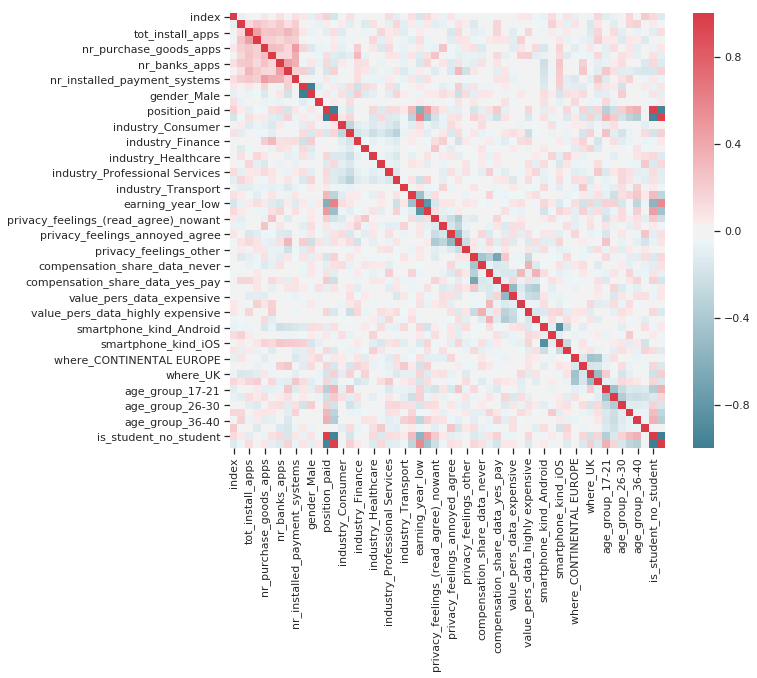

In [12]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data_dummies.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

From the correlation matrix it can be inferred that:

- there are no features higlhly linearly correlated;
- the other features don't seem to be correlated linearly.

Now we can ignore the columns with values consistently close to zero in the correlation matrix. If two or more columns are strongly correlated with each other, any one of them would be sufficient to capture the essence of the other columns.

# 3) QUESTIONS

In [13]:
# descriptive plot function
def plot_violin(data, col, y, palette):
    for x in col:
        sns.catplot(x, y, kind="violin", inner='box', palette=palette, data=data, split=True)
        plt.title(x + ' VS ' + y)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.xticks(rotation=90)

# function for partial residuals
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def plot_partial_residual(res, col):
    fig = res.plot_partial_residuals(col)


    col_beta = res.params[col] 
    ax = fig.get_axes()[0]
    #ax.plot((0.0,1), (0, col_beta))
    abline(col_beta, 0)
    ax.get_lines()[0].set_alpha(0.5)

# Note: uses sm.families.NegativeBinomial to fit alpha, then use glm for convenience    
def negativeBinomial(formula, data, method='bfgs', iter=5000):
    print('negative binomial')
    y, X = patsy.dmatrices(formula, data=data, return_type='dataframe')

    mod = sm.NegativeBinomial(y, X)
    res = mod.fit(maxiter=iter, maxfun=iter, method=method)

    mod.mu = res.predict()
    display(res.summary())
    alpha = math.exp(res.lnalpha)
    return smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(sm.families.links.log, alpha=alpha))

def print_log_effect(res, col):
    print('baseline: {:.2f} ±{:.2f}, effect: {:.2f}% ±{:.2f}%'.format(math.exp(res.params['Intercept']), 
                                        math.exp(res.bse['Intercept']),
                                        (math.exp(res.params[col])-1)*100, 
                                        (math.exp(res.bse[col])-1)*100,
                                       ))
    


# 3.1) Do unpaid users install more social networks and how much do users install?

3.1.1) PRELIMINARY DESCRIPTIVE PLOTS

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


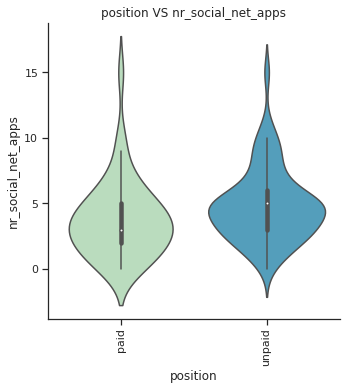

In [14]:
plot_violin(data1, ['position'], 'nr_social_net_apps', 'GnBu')

Violin plots are particularly useful to show information on the distribution shape of the data, expecially if the data has normal distribution. Wider sections of the violin plot represent a higher probability that members of the population will take on the given value; the skinnier sections represent a lower probability.

The shape of the distribution (extremely skinny on each end and wide in the middle) appears to be normal for both paid and unpaid positions, indicating that the number of applications are highly concentrated around the median.
It can be noticed that both unpaid and paid positions have a long-tail distribution above the third quartile in all the plots above, more evident in paid positions. 
The distribution for unpaid users is wider than the distribution of paid users. The median value of social network applications for unpaid users is greater than that one for paid users.

A model to fit these data is needed to check if they are statistical relevant.

3.1.2) MODEL

a) ASSUMPTIONS:

- The data x1, x2, ..., xn are independently distributed, i.e., cases are independent.
- The dependent variable Yi does NOT need to be normally distributed, but it typically assumes a distribution from an exponential family (Negative Binomial in this case)
- GLM does NOT assume a linear relationship between the dependent variable and the independent variables, but it does assume linear relationship between the transformed response in terms of the link function and the explanatory variables;
- Independent (explanatory) variables can be even the power terms or some other nonlinear transformations of the original independent variables.

b) MODEL:

- dependent variable Y = 'nr_social_net_apps'
- independent explanatory variables x1, x2, ..xn = 'position'

negative binomial
Optimization terminated successfully.
         Current function value: 2.355206
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:     nr_social_net_apps   No. Observations:                  161
Model:               NegativeBinomial   Df Residuals:                      159
Method:                           MLE   Df Model:                            1
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                0.006529
Time:                        20:07:08   Log-Likelihood:                -379.19
converged:                       True   LL-Null:                       -381.68
                                        LLR p-value:                   0.02558
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.3264      0.098     13.573      0.000       1.135       1.518
C(position)[T.unpaid]     0.2503      0.112      2.236      0.025       0.031       0.470
alpha                     0.1452      0.041      3.499      0.000       0.064       0.227
=========================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     nr_social_net_apps   No. Observations:                  161
Model:                            GLM   Df Residuals:                      159
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.19
Date:                Sat, 27 Apr 2019   Deviance:                       172.81
Time:                        20:07:08   Pearson chi2:                     171.
No. Iterations:                     4   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.3264      0.098     13.573      0.000       1.135       1.518
C(position)[T.unpaid]     0.2503      0.112      2.236      0.025       0.031       0.470
=========================================================================================
"""

baseline: 3.77 ±1.10, effect: 28.44% ±11.84%


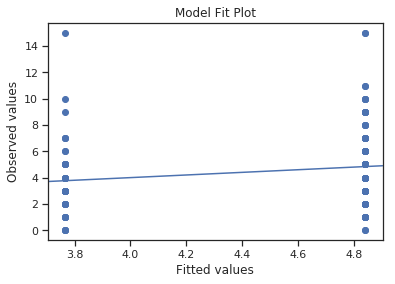

In [15]:
# Negative Binomial
mod = negativeBinomial(formula='nr_social_net_apps ~ C(position) ', data=data1)
res = mod.fit()
display(res.summary())

nobs = res.nobs
y = res._endog[:]
yhat = res.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');
    
print_log_effect(res, 'C(position)[T.unpaid]')


c) PARTIAL RESIDUAL PLOTS

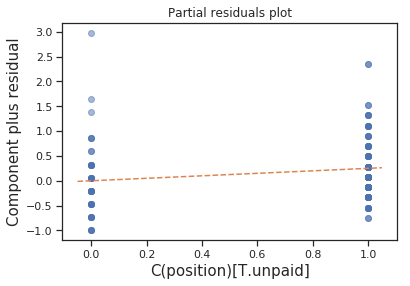

In [16]:
plot_partial_residual(res, col='C(position)[T.unpaid]')

3.1.3) CONCLUSIONS

    The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable.
    Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response.

    The table above show that the predictor variables are significant;
    The residual plot shows that it's more likely that unpaid users (students and interns) download more social network apps  (about 30% more apps than average) than users with a paid position, who, on average install 3.68 applications.

# 3.2) Do unpaid users use more purchasing goods apps and how much do users install?

3.2.1) PRELIMINARY DESCRIPTIVE PLOTS

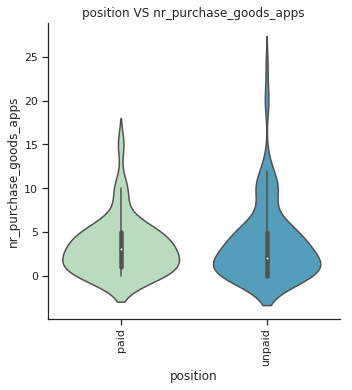

In [17]:
plot_violin(data1, ['position'], 'nr_purchase_goods_apps', 'GnBu')

The previous violin plot shows the relationship between the unpaid (students plus interns)-paid position and the number of purchasing goods apps downloaded by the users.
The shape of the distribution (extremely skinny on each end and wide in the middle) appears to be normal for both paid and unpaid positions, indicating that the number of applications are highly concentrated around the median.
It can be noticed that both unpaid and paid positions have a long-tail distribution above the third quartile in all the plots above, more evident in unpaid positions. 
The distribution for paid users is wider than the distribution of paid users. The median value of purchasing goods applications for paid users is greater than that one for unpaid users.

3.2.2) MODEL

a) ASSUMPTIONS:

-  see point 3.1.2 a)

b) MODEL:

- dependent variable Y = 'nr_purchase_goods_apps'
- independent explanatory variables x1, x2, ..xn = 'position'

negative binomial
Optimization terminated successfully.
         Current function value: 2.402976
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                       NegativeBinomial Regression Results                        
==================================================================================
Dep. Variable:     nr_purchase_goods_apps   No. Observations:                  161
Model:                   NegativeBinomial   Df Residuals:                      159
Method:                               MLE   Df Model:                            1
Date:                    Sat, 27 Apr 2019   Pseudo R-squ.:               0.0005763
Time:                            20:07:16   Log-Likelihood:                -386.88
converged:                           True   LL-Null:                       -387.10
                                            LLR p-value:                    0.5042
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.1733      0.177      6.640      0.000       0.827       1.520
C(position)[T.unpaid]     0.1383      0.206      0.673      0.501      -0.265       0.541
alpha                     1.0331      0.163      6.320      0.000       0.713       1.354
=========================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     nr_purchase_goods_apps   No. Observations:                  161
Model:                                GLM   Df Residuals:                      159
Model Family:            NegativeBinomial   Df Model:                            1
Link Function:                        log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -386.88
Date:                    Sat, 27 Apr 2019   Deviance:                       182.94
Time:                            20:07:16   Pearson chi2:                     155.
No. Iterations:                         5   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.1733      0.177      6.640      0.000       0.827       1.520
C(position)[T.unpaid]     0.1383      0.206      0.673      0.501      -0.265       0.541
=========================================================================================
"""

baseline: 3.23 ±1.19, effect: 14.83% ±22.82%


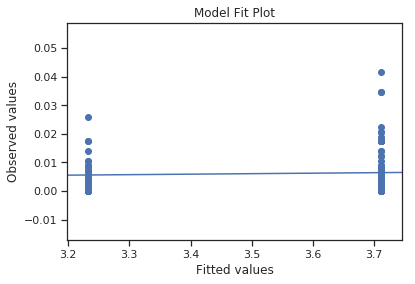

In [18]:
# Negative Binomial
mod = negativeBinomial(formula='nr_purchase_goods_apps ~ C(position) ', data=data1)
res = mod.fit()
display(res.summary())

nobs = res.nobs
y = res._endog[:]/res._endog.sum()
yhat = res.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

print_log_effect(res, 'C(position)[T.unpaid]')

3.2.3) CONCLUSIONS

    The results are not statistical significative.

# 3.3) Do unpaid users install more subscription apps and how much do users install?

3.3.1) PRELIMINARY DESCRIPTIVE PLOTS

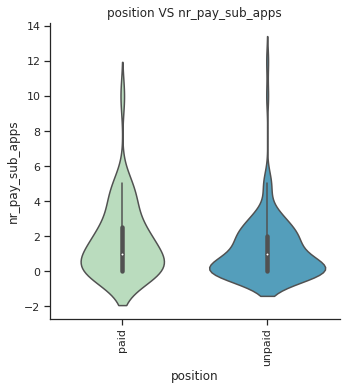

In [19]:
plot_violin(data1, ['position'], 'nr_pay_sub_apps', 'GnBu')

The shape of the distribution is normal for both paid and unpaid positions, indicating that the number of applications are highly concentrated around the median.
It can be noticed that both unpaid and paid positions have a long-tail distribution above the third quartile in all the plots above, more evident in unpaid positions. 
The distribution for unpaid users is wider than the distribution of paid users. The median values of subscription applications for unpaidand paid users appear to be similar.

3.3.2) MODEL

a) ASSUMPTIONS:

-  see point 3.1.2 a)

b) MODEL:

- dependent variable Y = 'nr_pay_subs_apps'
- independent explanatory variables x1, x2, ..xn = 'position'

negative binomial
Optimization terminated successfully.
         Current function value: 1.608132
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:        nr_pay_sub_apps   No. Observations:                  161
Model:               NegativeBinomial   Df Residuals:                      159
Method:                           MLE   Df Model:                            1
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                0.003607
Time:                        20:07:35   Log-Likelihood:                -258.91
converged:                       True   LL-Null:                       -259.85
                                        LLR p-value:                    0.1710
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5429      0.199      2.727      0.006       0.153       0.933
C(position)[T.unpaid]    -0.3231      0.237     -1.366      0.172      -0.787       0.141
alpha                     1.1234      0.256      4.384      0.000       0.621       1.626
=========================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        nr_pay_sub_apps   No. Observations:                  161
Model:                            GLM   Df Residuals:                      159
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -258.91
Date:                Sat, 27 Apr 2019   Deviance:                       165.45
Time:                        20:07:35   Pearson chi2:                     168.
No. Iterations:                     5   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5429      0.199      2.727      0.006       0.153       0.933
C(position)[T.unpaid]    -0.3231      0.237     -1.366      0.172      -0.787       0.141
=========================================================================================
"""

baseline: 1.72 ±1.22, effect: -27.61% ±26.69%


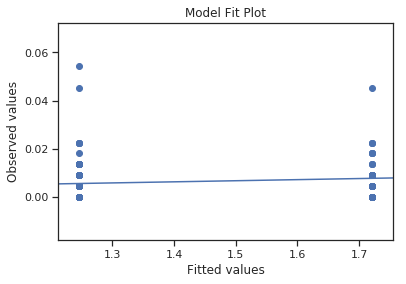

In [20]:
# Negative Binomial
mod = negativeBinomial(formula='nr_pay_sub_apps ~ C(position) ', data=data1)
res = mod.fit()
display(res.summary())

nobs = res.nobs
y = res._endog[:]/res._endog.sum()
yhat = res.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

print_log_effect(res, 'C(position)[T.unpaid]')

c) PARTIAL RESIDUAL PLOTS

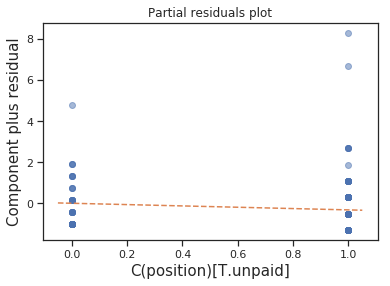

In [21]:
plot_partial_residual(res, col='C(position)[T.unpaid]')

3.3.3) CONCLUSIONS
    
    The results are not statistical significative as the p-value of the predictor is greater than the threshold.

# 3.4) Do unpaid users install more banks apps and how much do users install?

3.4.1) PRELIMINARY DESCRIPTIVE PLOTS

In [22]:
data1.columns

Index(['index', 'gender', 'position', 'industry', 'earning_year',
       'privacy_feelings', 'compensation_share_data', 'value_pers_data',
       'smartphone_kind', 'nr_devices', 'tot_install_apps', 'nr_install_games',
       'nr_purchase_goods_apps', 'nr_pay_sub_apps', 'nr_banks_apps',
       'nr_social_net_apps', 'nr_installed_payment_systems', 'where',
       'is_student', 'age_group'],
      dtype='object')

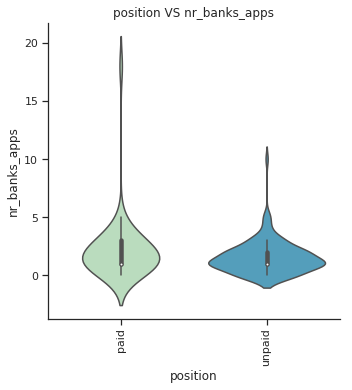

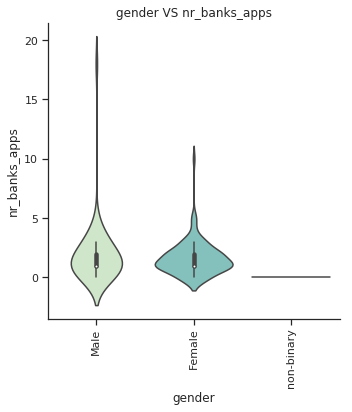

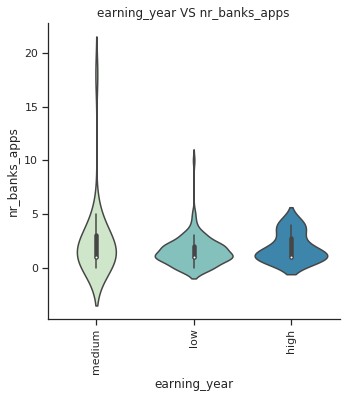

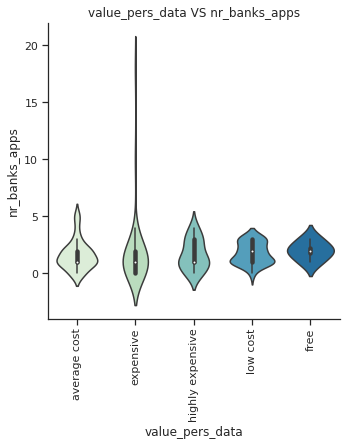

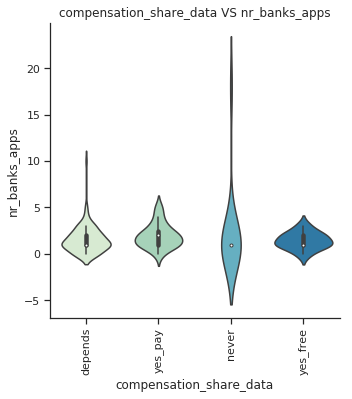

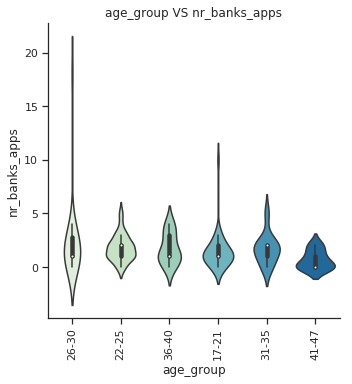

In [23]:
plot_violin(data1, ['position', 'gender', 'earning_year', 'value_pers_data', 'compensation_share_data', 'age_group'], 'nr_banks_apps', 'GnBu')

The shape of the distribution is normal for both paid and unpaid positions, indicating that the number of applications are highly concentrated around the median.
It can be noticed that both unpaid and paid positions have a long-tail distribution above the third quartile in all the plots above, more evident in paid positions. 
The distribution for unpaid users is wider than the distribution of paid users. The median values of bank applications for unpaidand paid users appear to be similar.

3.4.2) MODEL

a) ASSUMPTIONS:

-  see point 3.1.2 a)

b) MODEL:

- dependent variable Y = 'nr_banks_apps'
- independent explanatory variables x1, x2, ..xn = 'position'

negative binomial
Optimization terminated successfully.
         Current function value: 1.666233
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:          nr_banks_apps   No. Observations:                  161
Model:               NegativeBinomial   Df Residuals:                      159
Method:                           MLE   Df Model:                            1
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                0.007841
Time:                        20:07:57   Log-Likelihood:                -268.26
converged:                       True   LL-Null:                       -270.38
                                        LLR p-value:                   0.03948
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.7497      0.128      5.862      0.000       0.499       1.000
C(position)[T.unpaid]    -0.3218      0.154     -2.085      0.037      -0.624      -0.019
alpha                     0.2307      0.079      2.918      0.004       0.076       0.386
=========================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          nr_banks_apps   No. Observations:                  161
Model:                            GLM   Df Residuals:                      159
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -268.26
Date:                Sat, 27 Apr 2019   Deviance:                       157.05
Time:                        20:07:57   Pearson chi2:                     209.
No. Iterations:                     4   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.7497      0.128      5.862      0.000       0.499       1.000
C(position)[T.unpaid]    -0.3218      0.154     -2.085      0.037      -0.624      -0.019
=========================================================================================
"""

baseline: 2.12 ±1.14, effect: -27.52% ±16.69%


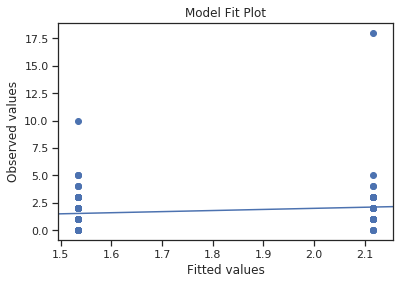

In [24]:
# Negative Binomial
mod = negativeBinomial(formula='nr_banks_apps ~ C(position) ', data=data1)
res = mod.fit()
display(res.summary())

nobs = res.nobs
y = res._endog[:]
yhat = res.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

print_log_effect(res, 'C(position)[T.unpaid]')

c) PARTIAL RESIDUAL PLOTS

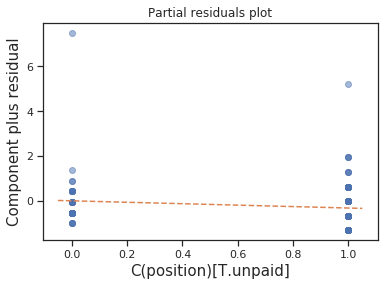

In [25]:
plot_partial_residual(res, col='C(position)[T.unpaid]')

3.4.3) CONCLUSIONS

    From the table and plots above, it can be noticed that the all predictor variables are statistical significant as their p-values are around 0.05. In particular the unpaid users seem to download less bank applications (circa 27% less applications than paid users) than paid users, who, on average download 2 bank applications.

# 3.5) How many apps do people with different feelings about Privacy install ? Do they install more or less?

3.5.1) PRELIMINARY DESCRIPTIVE PLOTS

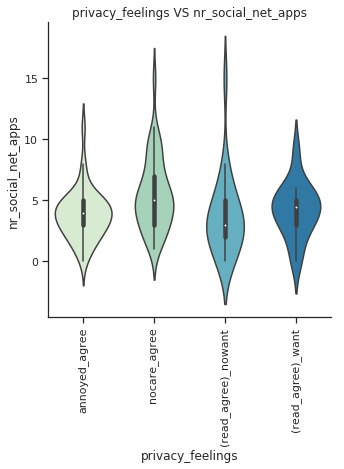

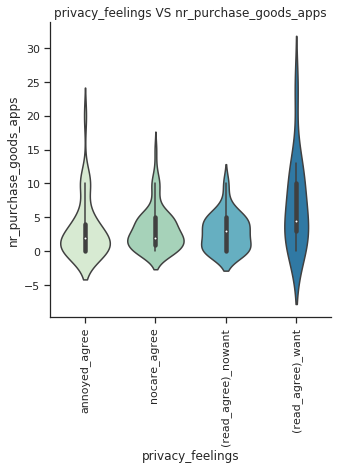

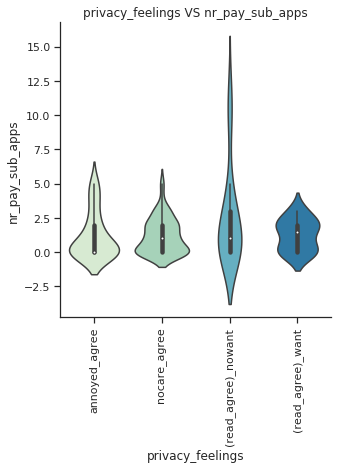

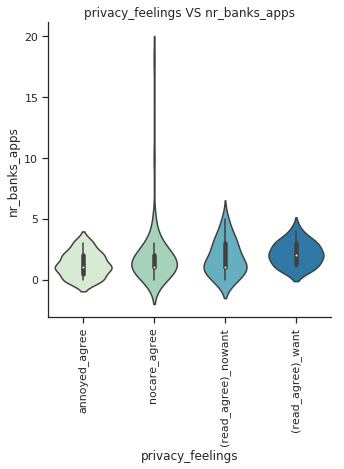

In [26]:
plot_violin(data1[data1['privacy_feelings'] != 'other'], ['privacy_feelings'], 'nr_social_net_apps', 'GnBu')
plot_violin(data1[data1['privacy_feelings'] != 'other'], ['privacy_feelings'], 'nr_purchase_goods_apps', 'GnBu')
plot_violin(data1[data1['privacy_feelings'] != 'other'], ['privacy_feelings'], 'nr_pay_sub_apps', 'GnBu')
plot_violin(data1[data1['privacy_feelings'] != 'other'], ['privacy_feelings'], 'nr_banks_apps', 'GnBu')

The following observations can be made from this preliminary analysis:

    - The majority of the distributions appear to be normal with some predictors having long-tail distributions either above the third quartile or below the first quartile;
    - The users who don't care about the privacy policies on applications and the users who agree to the privacy policies when they want seem to download more social network applications than other users.
    - The users who seem to download less social network applications are the users who agree to the privacy policies even if don't want to agree.
    - The users who install more purchasing goods and more banks applications appear to be the users who agree to privacy policies when they want.

3.5.2.1) MODEL

a) ASSUMPTIONS:

- see 3.1.2)

b) MODELS:

- dependent variable Y = 'tot_installed_apps'
- independent explanatory variables x1, x2, ..xn = 'privacy_feelings'

negative binomial
Optimization terminated successfully.
         Current function value: 4.461442
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:       tot_install_apps   No. Observations:                  161
Model:               NegativeBinomial   Df Residuals:                      156
Method:                           MLE   Df Model:                            4
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                0.004348
Time:                        20:08:15   Log-Likelihood:                -718.29
converged:                       True   LL-Null:                       -721.43
                                        LLR p-value:                    0.1797
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    3.4644      0.157     22.104      0.000       3.157       3.772
C(privacy_feelings)[T.(read_agree)_want]     0.1388      0.254      0.546      0.585      -0.359       0.637
C(privacy_feelings)[T.annoyed_agree]        -0.1743      0.198     -0.880      0.379      -0.562       0.214
C(privacy_feelings)[T.nocare_agree]          0.1914      0.179      1.071      0.284      -0.159       0.542
C(privacy_feelings)[T.other]                 0.1877      0.295      0.637      0.524      -0.390       0.765
alpha                                        0.5337      0.059      9.007      0.000       0.418       0.650
============================================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       tot_install_apps   No. Observations:                  161
Model:                            GLM   Df Residuals:                      156
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -718.29
Date:                Sat, 27 Apr 2019   Deviance:                       173.38
Time:                        20:08:15   Pearson chi2:                     203.
No. Iterations:                     5   Covariance Type:             nonrobust
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    3.4644      0.157     22.104      0.000       3.157       3.772
C(privacy_feelings)[T.(read_agree)_want]     0.1388      0.254      0.546      0.585      -0.359       0.637
C(privacy_feelings)[T.annoyed_agree]        -0.1743      0.198     -0.880      0.379      -0.562       0.214
C(privacy_feelings)[T.nocare_agree]          0.1914      0.179      1.071      0.284      -0.159       0.542
C(privacy_feelings)[T.other]                 0.1877      0.295      0.637      0.524      -0.390       0.765
============================================================================================================
"""

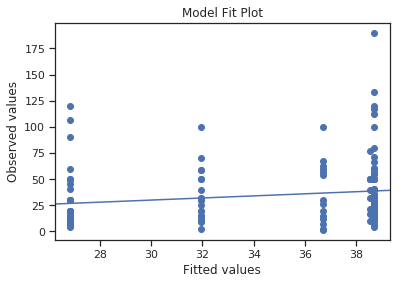

In [27]:
# Negative binomial
mod = negativeBinomial(formula='tot_install_apps ~ C(privacy_feelings) ', data=data1)
res = mod.fit()
display(res.summary())

nobs = res.nobs
y = res._endog[:]
yhat = res.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

c) PARTIAL RESIDUAL PLOTS

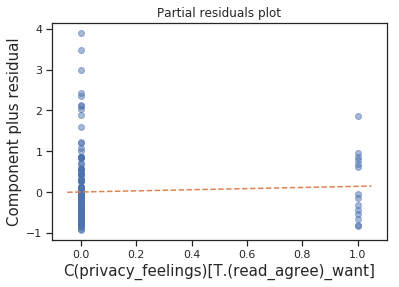

In [28]:
plot_partial_residual(res, col='C(privacy_feelings)[T.(read_agree)_want]')

3.4.3) CONCLUSIONS

    The results are not statistically significant.

# 3.6) How much do users install?

3.6.1) MODEL

a) ASSUMPTIONS:

- see 3.1.2)

b) MODELS:

- dependent variable Y = 'tot_installed_apps'
- independent explanatory variables x1, x2, ..xn = 'privacy_feelings'

Optimization terminated successfully.
         Current function value: 4.480924
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:       tot_install_apps   No. Observations:                  161
Model:               NegativeBinomial   Df Residuals:                      160
Method:                           MLE   Df Model:                            0
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:               2.900e-12
Time:                        20:08:26   Log-Likelihood:                -721.43
converged:                       True   LL-Null:                       -721.43
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5463      0.060     58.965      0.000       3.428       3.664
alpha          0.5535      0.061      9.058      0.000       0.434       0.673
==============================================================================
"""

baseline: 34.68 ±1.06


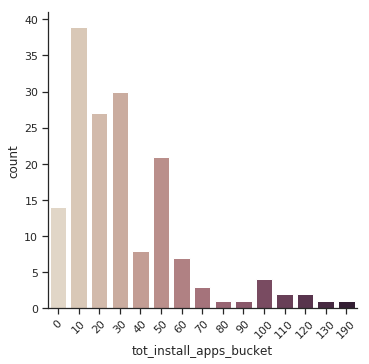

In [29]:
# Negative Binomial
y, X = patsy.dmatrices('tot_install_apps ~ 1 ', data=data1, return_type='dataframe')

mod = sm.NegativeBinomial(y, X)
res = mod.fit()

mu = res.predict()
display(res.summary())
alpha = res.params[1]

size = 1. / alpha 
prob = size / (size + mu)

#estimated distribution
dist_est = nbinom(size, prob)

nobs = res.nobs
yhat = mu

data1['tot_install_apps_bucket'] = data1['tot_install_apps'].apply(lambda x: math.floor(x/10)*10)

a = sns.catplot(x="tot_install_apps_bucket", kind="count", palette="ch:.25", data=data1)
a.set_xticklabels(rotation=45)
display(a)
print('baseline: {:.2f} ±{:.2f}'.format(math.exp(res.params['Intercept']), 
                                        math.exp(res.bse['Intercept']),
                                       ))

In [30]:
data1.columns

Index(['index', 'gender', 'position', 'industry', 'earning_year',
       'privacy_feelings', 'compensation_share_data', 'value_pers_data',
       'smartphone_kind', 'nr_devices', 'tot_install_apps', 'nr_install_games',
       'nr_purchase_goods_apps', 'nr_pay_sub_apps', 'nr_banks_apps',
       'nr_social_net_apps', 'nr_installed_payment_systems', 'where',
       'is_student', 'age_group', 'tot_install_apps_bucket'],
      dtype='object')

Distribution of tot_install_apps
Optimization terminated successfully.
         Current function value: 4.480924
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:       tot_install_apps   No. Observations:                  161
Model:               NegativeBinomial   Df Residuals:                      160
Method:                           MLE   Df Model:                            0
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:               2.900e-12
Time:                        20:08:30   Log-Likelihood:                -721.43
converged:                       True   LL-Null:                       -721.43
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5463      0.060     58.965      0.000       3.428       3.664
alpha          0.5535      0.061      9.058      0.000       0.434       0.673
==============================================================================
"""

baseline: 34.68 ±1.06



Distribution of nr_install_games
Optimization terminated successfully.
         Current function value: 2.704852
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:       nr_install_games   No. Observations:                  161
Model:               NegativeBinomial   Df Residuals:                      160
Method:                           MLE   Df Model:                            0
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:               1.711e-11
Time:                        20:08:30   Log-Likelihood:                -435.48
converged:                       True   LL-Null:                       -435.48
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6615      0.107     15.474      0.000       1.451       1.872
alpha          1.6664      0.224      7.436      0.000       1.227       2.106
==============================================================================
"""

baseline: 5.27 ±1.11



Distribution of nr_purchase_goods_apps
Optimization terminated successfully.
         Current function value: 2.404361
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                       NegativeBinomial Regression Results                        
==================================================================================
Dep. Variable:     nr_purchase_goods_apps   No. Observations:                  161
Model:                   NegativeBinomial   Df Residuals:                      160
Method:                               MLE   Df Model:                            0
Date:                    Sat, 27 Apr 2019   Pseudo R-squ.:               1.076e-11
Time:                            20:08:30   Log-Likelihood:                -387.10
converged:                           True   LL-Null:                       -387.10
                                            LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2764      0.090     14.115      0.000       1.099       1.454
alpha          1.0376      0.164      6.330      0.000       0.716       1.359
==============================================================================
"""

baseline: 3.58 ±1.09



Distribution of nr_pay_sub_apps
Optimization terminated successfully.
         Current function value: 1.613953
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:        nr_pay_sub_apps   No. Observations:                  161
Model:               NegativeBinomial   Df Residuals:                      160
Method:                           MLE   Df Model:                            0
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:               3.728e-11
Time:                        20:08:31   Log-Likelihood:                -259.85
converged:                       True   LL-Null:                       -259.85
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3168      0.108      2.927      0.003       0.105       0.529
alpha          1.1574      0.260      4.443      0.000       0.647       1.668
==============================================================================
"""

baseline: 1.37 ±1.11



Distribution of nr_banks_apps
Optimization terminated successfully.
         Current function value: 1.679401
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:          nr_banks_apps   No. Observations:                  161
Model:               NegativeBinomial   Df Residuals:                      160
Method:                           MLE   Df Model:                            0
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:              -2.404e-10
Time:                        20:08:31   Log-Likelihood:                -270.38
converged:                       True   LL-Null:                       -270.38
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5244      0.072      7.262      0.000       0.383       0.666
alpha          0.2477      0.082      3.025      0.002       0.087       0.408
==============================================================================
"""

baseline: 1.69 ±1.07



Distribution of nr_social_net_apps
Optimization terminated successfully.
         Current function value: 2.370684
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:     nr_social_net_apps   No. Observations:                  161
Model:               NegativeBinomial   Df Residuals:                      160
Method:                           MLE   Df Model:                            0
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:               1.443e-11
Time:                        20:08:31   Log-Likelihood:                -381.68
converged:                       True   LL-Null:                       -381.68
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5157      0.048     31.344      0.000       1.421       1.611
alpha          0.1569      0.043      3.657      0.000       0.073       0.241
==============================================================================
"""

baseline: 4.55 ±1.05



Distribution of nr_installed_payment_systems
         Current function value: inf
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2


/home/egor/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:155: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/home/egor/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/egor/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/egor/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:563: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
/home/egor/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ego

<class 'statsmodels.iolib.summary.Summary'>
"""
                          NegativeBinomial Regression Results                           
========================================================================================
Dep. Variable:     nr_installed_payment_systems   No. Observations:                  161
Model:                         NegativeBinomial   Df Residuals:                      160
Method:                                     MLE   Df Model:                            0
Date:                          Sat, 27 Apr 2019   Pseudo R-squ.:                     nan
Time:                                  20:08:34   Log-Likelihood:                   -inf
converged:                                False   LL-Null:                          -inf
                                                  LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1865        nan        nan        nan         nan         nan
alpha          3.7026        nan        nan        nan         nan         nan
==============================================================================
"""

baseline: 1.20 ±nan





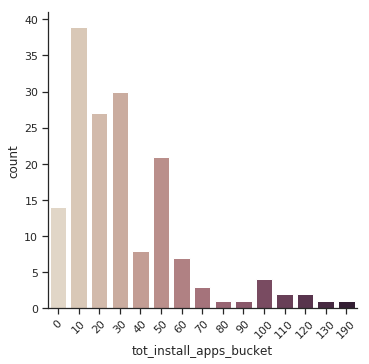

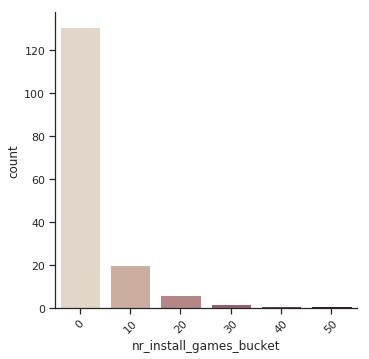

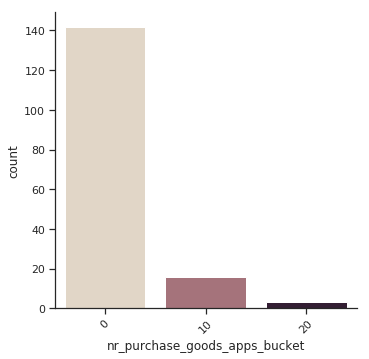

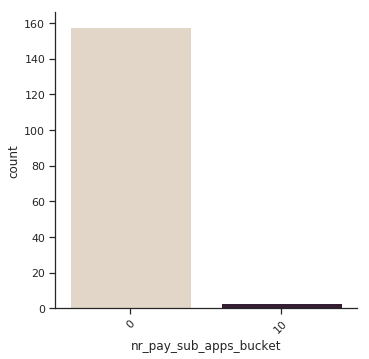

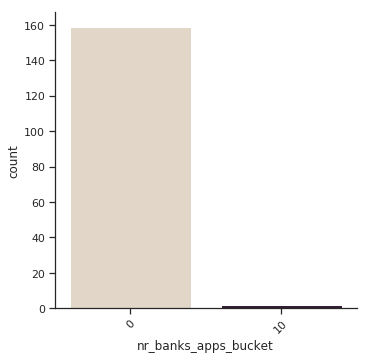

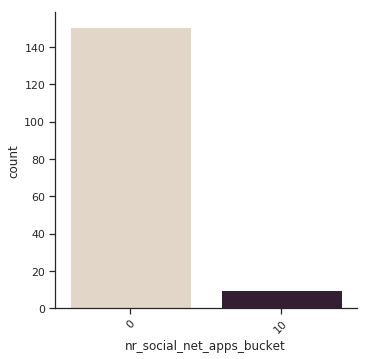

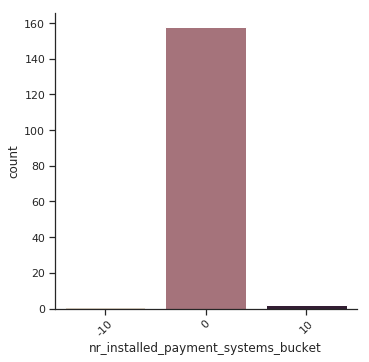

In [31]:
number_columns = ['tot_install_apps', 'nr_install_games',
       'nr_purchase_goods_apps', 'nr_pay_sub_apps', 'nr_banks_apps',
       'nr_social_net_apps', 'nr_installed_payment_systems']

for nc in number_columns:
    print('Distribution of ' + nc)
    # Negative Binomial
    y, X = patsy.dmatrices(nc + ' ~ 1 ', data=data1, return_type='dataframe')

    mod = sm.NegativeBinomial(y, X)
    res = mod.fit()

    mu = res.predict()
    display(res.summary())
    alpha = res.params[1]

    size = 1. / alpha 
    prob = size / (size + mu)

    #estimated distribution
    dist_est = nbinom(size, prob)

    nobs = res.nobs
    yhat = mu

    data1[nc + '_bucket'] = data1[nc].apply(lambda x: math.floor(x/10)*10)

    a = sns.catplot(x=nc + "_bucket", kind="count", palette="ch:.25", data=data1)
    a.set_xticklabels(rotation=45)
    display(a)
    print('baseline: {:.2f} ±{:.2f}'.format(math.exp(res.params['Intercept']), 
                                            math.exp(res.bse['Intercept']),
                                           ))
    print('\n\n')

3.6.2) CONCLUSIONS

The number of installed apps can be well represented with a negative binomial distribution. The average is 34 applications.

# 3.7) How many apps do people with different feelings about Privacy install? do they install more or less?

3.7.1) PRELIMINARY DESCRIPTIVE PLOTS

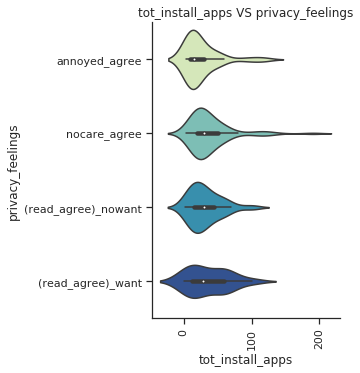

In [32]:
plot_violin(data1.drop(data1[data1['privacy_feelings'] == 'other'].index), 
            ['tot_install_apps'],
            'privacy_feelings','YlGnBu')

The following observations can be made from this preliminary analysis:

    - The majority of the distributions appear to be normal with some predictors having long-tail distributions either above the third quartile or below the first quartile;
    - The users who don't care about the privacy policies on applications and the users who agree to the privacy policies when they want seem to download more social network applications and more no-social network applications than other users.
    - The users who seem to download less (no-social network and social network applications) are the people annoyed by the privacy policies but agree to them and the users who agree to the privacy policies even if don't want to agree.

3.7.2) MODEL

a) ASSUMPTIONS:

- see 3.1.2)

b) MODEL:

    - dependent variable Y = 'tot_install_apps'
    - independent explanatory variables x1, x2, ..xn = 'privacy_feelings'

negative binomial
Optimization terminated successfully.
         Current function value: 4.461480
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:       tot_install_apps   No. Observations:                  152
Model:               NegativeBinomial   Df Residuals:                      148
Method:                           MLE   Df Model:                            3
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                0.004345
Time:                        20:08:52   Log-Likelihood:                -678.15
converged:                       True   LL-Null:                       -681.10
                                        LLR p-value:                    0.1157
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    3.4644      0.159     21.810      0.000       3.153       3.776
C(privacy_feelings)[T.(read_agree)_want]     0.1388      0.258      0.539      0.590      -0.366       0.644
C(privacy_feelings)[T.annoyed_agree]        -0.1743      0.201     -0.868      0.385      -0.568       0.219
C(privacy_feelings)[T.nocare_agree]          0.1914      0.181      1.057      0.291      -0.164       0.546
alpha                                        0.5490      0.063      8.780      0.000       0.426       0.672
============================================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       tot_install_apps   No. Observations:                  152
Model:                            GLM   Df Residuals:                      148
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -678.15
Date:                Sat, 27 Apr 2019   Deviance:                       163.93
Time:                        20:08:52   Pearson chi2:                     193.
No. Iterations:                     5   Covariance Type:             nonrobust
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    3.4644      0.159     21.810      0.000       3.153       3.776
C(privacy_feelings)[T.(read_agree)_want]     0.1388      0.258      0.539      0.590      -0.366       0.644
C(privacy_feelings)[T.annoyed_agree]        -0.1743      0.201     -0.868      0.385      -0.568       0.219
C(privacy_feelings)[T.nocare_agree]          0.1914      0.181      1.057      0.291      -0.164       0.546
============================================================================================================
"""

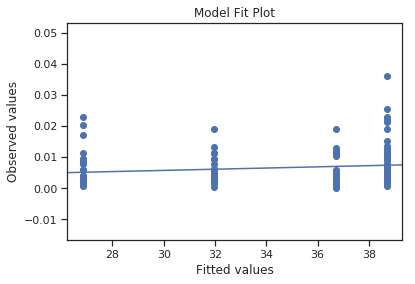

In [33]:
# Negative Binomial
mod = negativeBinomial(formula='tot_install_apps ~ C(privacy_feelings)', data=data1[data1['privacy_feelings'] != 'other'])
res = mod.fit()
display(res.summary())

nobs = res.nobs
y = res._endog[:]/res._endog.sum()
yhat = res.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');


3.7.3) CONCLUSIONS

The results do not seem statistically significant.

# 3.8) WHO ARE THE GAMERS?

3.8.1) PRELIMINARY DESCRIPTIVE PLOTS

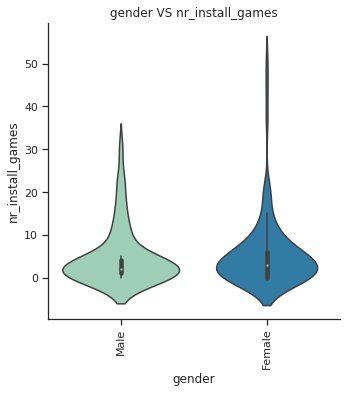

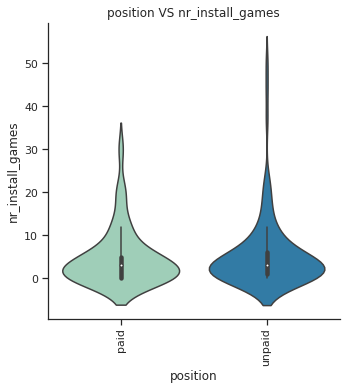

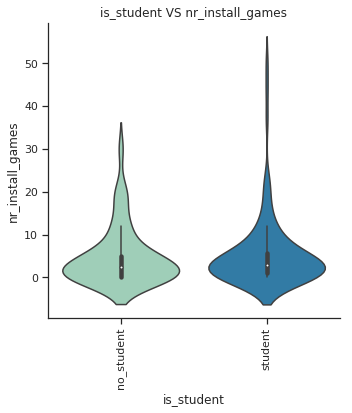

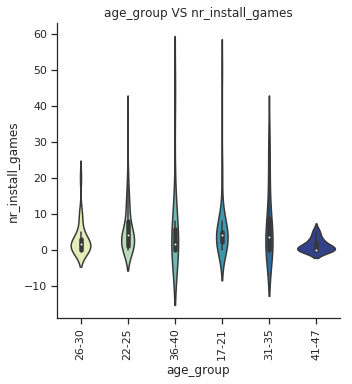

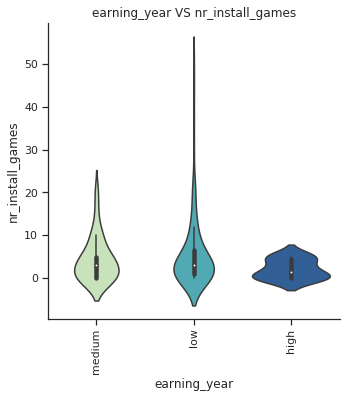

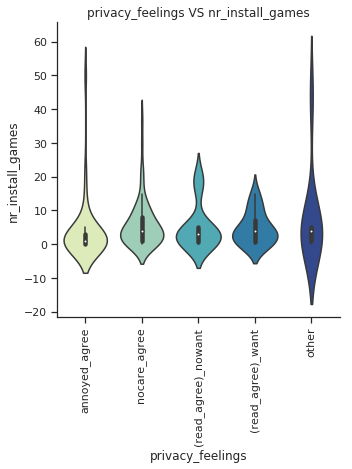

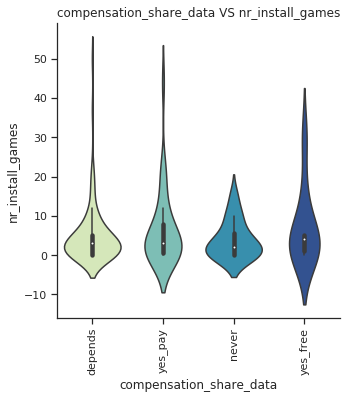

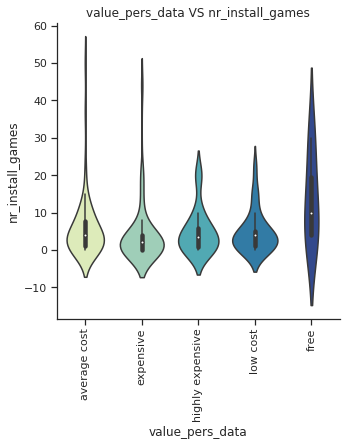

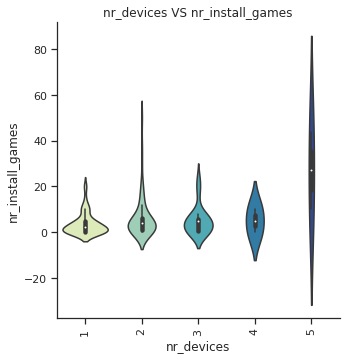

In [34]:
plot_violin(data1.drop(data1[data1['gender'] == 'non-binary'].index), 
            ['gender', 'position', 'is_student', 'age_group', 'earning_year', 
             'privacy_feelings', 'compensation_share_data', 'value_pers_data', 'nr_devices'],
            'nr_install_games','YlGnBu')

The following observations can be made from this preliminary analysis:

    - The majority of the distributions appear to be normal with some predictors having long-tail distributions either above the third quartile or below the first quartile;
    - The users who installed more games appear to be female;
    - Paid and Unpaid (students and interns) users seem to install a similar amount of games;
    - The younger user seem to download more games than the older ones;
    - The users earning more seem to install more games than users having medium and low earnings;
    - The users seem to install games independently by their feelings about compensation for sharing personal data and their feelings about privacy policies;
    - The users who value their personal data as free seem to download more than other users;
    - The users owning an high number of devices seem to download more games;
    
Let's find a model to fit the data in order to check if the previous results are statistical relevant.

3.8.2) MODEL

a) ASSUMPTIONS:

- see 3.1.2)

b) MODELS:

- dependent variable Y = 'nr_install_games'
- independent explanatory variables x1, x2, ..xn = 
                    'gender', 'position', 'earning_year',
                    'compensation_share_data', 'value_pers_data',
                    'privacy_feelings', 'smartphone_kind', 'age_group'

negative binomial
Optimization terminated successfully.
         Current function value: 2.615052
         Iterations: 83
         Function evaluations: 84
         Gradient evaluations: 84


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:       nr_install_games   No. Observations:                  160
Model:               NegativeBinomial   Df Residuals:                      136
Method:                           MLE   Df Model:                           23
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                 0.03147
Time:                        20:09:03   Log-Likelihood:                -418.41
converged:                       True   LL-Null:                       -432.00
                                        LLR p-value:                    0.2481
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    1.3129      0.647      2.029      0.042       0.045       2.581
C(gender)[T.Male]                           -0.1285      0.248     -0.518      0.604      -0.615       0.358
C(position)[T.unpaid]                       -0.2763      0.393     -0.703      0.482      -1.047       0.494
C(earning_year)[T.low]                       0.9250      0.575      1.608      0.108      -0.203       2.053
C(earning_year)[T.medium]                    0.4850      0.555      0.874      0.382      -0.603       1.572
C(compensation_share_data)[T.never]          0.0027      0.431      0.006      0.995      -0.843       0.848
C(compensation_share_data)[T.yes_free]      -0.0616      0.580     -0.106      0.915      -1.198       1.075
C(compensation_share_data)[T.yes_pay]        0.4200      0.308      1.365      0.172      -0.183       1.023
C(value_pers_data)[T.expensive]             -0.6056      0.303     -2.000      0.046      -1.199      -0.012
C(value_pers_data)[T.free]                   1.0012      0.782      1.281      0.200      -0.531       2.533
C(value_pers_data)[T.highly expensive]      -0.3194      0.400     -0.798      0.425      -1.104       0.465
C(value_pers_data)[T.low cost]              -0.0669      0.351     -0.191      0.849      -0.755       0.621
C(privacy_feelings)[T.(read_agree)_want]     0.0866      0.500      0.173      0.863      -0.894       1.068
C(privacy_feelings)[T.annoyed_agree]        -0.3649      0.380     -0.959      0.338      -1.111       0.381
C(privacy_feelings)[T.nocare_agree]          0.0524      0.342      0.153      0.878      -0.618       0.723
C(privacy_feelings)[T.other]                 0.5091      0.589      0.864      0.388      -0.646       1.664
C(smartphone_kind)[T.Android and iOS]        0.3400      1.010      0.337      0.736      -1.639       2.319
C(smartphone_kind)[T.iOS]                    0.2921      0.247      1.185      0.236      -0.191       0.775
C(smartphone_kind)[T.other]                 -0.4737      0.504     -0.940      0.347      -1.461       0.514
C(age_group)[T.22-25]                       -0.2961      0.282     -1.049      0.294      -0.849       0.257
C(age_group)[T.26-30]                       -0.5750      0.380     -1.514      0.130      -1.319       0.169
C(age_group)[T.31-35]                       -0.5266      0.637     -0.827      0.408      -1.775       0.722
C(age_group)[T.36-40]                       -0.1795      0.552     -0.325      0.745      -1.262       0.903
C(age_group)[T.41-47]                       -1.2585      0.607     -2.072      0.038      -2.449      -0.068
alpha                                        1.3557      0.193      7.018      0.000       0.977       1.734
============================================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       nr_install_games   No. Observations:                  160
Model:                            GLM   Df Residuals:                      136
Model Family:        NegativeBinomial   Df Model:                           23
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -418.75
Date:                Sat, 27 Apr 2019   Deviance:                       178.94
Time:                        20:09:03   Pearson chi2:                     170.
No. Iterations:                   100   Covariance Type:             nonrobust
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    1.2210      0.650      1.879      0.060      -0.053       2.495
C(gender)[T.Male]                           -0.1536      0.234     -0.656      0.512      -0.613       0.305
C(position)[T.unpaid]                       -0.2266      0.368     -0.617      0.537      -0.947       0.494
C(earning_year)[T.low]                       0.9066      0.528      1.718      0.086      -0.128       1.941
C(earning_year)[T.medium]                    0.4549      0.534      0.853      0.394      -0.591       1.501
C(compensation_share_data)[T.never]          0.0637      0.416      0.153      0.878      -0.752       0.879
C(compensation_share_data)[T.yes_free]      -0.0776      0.525     -0.148      0.883      -1.107       0.952
C(compensation_share_data)[T.yes_pay]        0.4961      0.282      1.759      0.079      -0.057       1.049
C(value_pers_data)[T.expensive]             -0.5773      0.266     -2.173      0.030      -1.098      -0.057
C(value_pers_data)[T.free]                   1.0396      0.692      1.502      0.133      -0.317       2.396
C(value_pers_data)[T.highly expensive]      -0.3537      0.376     -0.940      0.347      -1.092       0.384
C(value_pers_data)[T.low cost]              -0.0306      0.331     -0.092      0.926      -0.680       0.619
C(privacy_feelings)[T.(read_agree)_want]     0.1272      0.454      0.280      0.779      -0.763       1.017
C(privacy_feelings)[T.annoyed_agree]        -0.3353      0.362     -0.927      0.354      -1.044       0.374
C(privacy_feelings)[T.nocare_agree]          0.1014      0.325      0.312      0.755      -0.535       0.738
C(privacy_feelings)[T.other]                 0.7017      0.528      1.328      0.184      -0.334       1.737
C(smartphone_kind)[T.Android and iOS]        0.3742      0.950      0.394      0.694      -1.488       2.237
C(smartphone_kind)[T.iOS]                    0.2731      0.227      1.205      0.228      -0.171       0.718
C(smartphone_kind)[T.other]                 -0.4335      0.496     -0.874      0.382      -1.406       0.539
C(age_group)[T.22-25]                       -0.2912      0.273     -1.065      0.287      -0.827       0.245
C(age_group)[T.26-30]                       -0.5493      0.371     -1.480      0.139      -1.277       0.178
C(age_group)[T.31-35]                       -0.4878      0.561     -0.870      0.385      -1.587       0.612
C(age_group)[T.36-40]                       -0.0552      0.507     -0.109      0.913      -1.048       0.938
C(age_group)[T.41-47]                       -1.2506      0.589     -2.125      0.034      -2.404      -0.097
============================================================================================================
"""

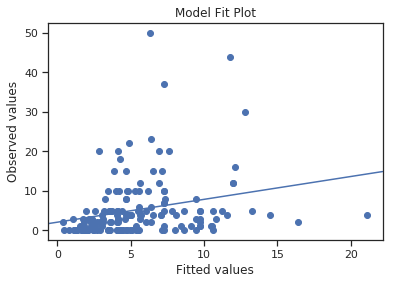

In [35]:
# Negative Binomial
mod = negativeBinomial(formula='nr_install_games ~ C(gender) + C(position) + C(earning_year) + C(compensation_share_data) + C(value_pers_data) + C(privacy_feelings) + C(smartphone_kind) + C(age_group) ', data=data1[data1['gender'] != 'non-binary'])
res = mod.fit()
display(res.summary())

nobs = res.nobs
y = res._endog[:]
yhat = res.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

The result does not seem to be statistically significant. We will try to apply a binomial model. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  gamer   No. Observations:                  161
Model:                            GLM   Df Residuals:                      136
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -89.742
Date:                Sat, 27 Apr 2019   Deviance:                       179.48
Time:                        20:09:09   Pearson chi2:                     154.
No. Iterations:                    19   Covariance Type:             nonrobust
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -0.4936      1.182     -0.418      0.676      -2.810       1.823
C(gender)[T.Male]                           -0.7186      0.435     -1.653      0.098      -1.571       0.134
C(gender)[T.non-binary]                     20.3720   1.77e+04      0.001      0.999   -3.47e+04    3.48e+04
C(position)[T.unpaid]                       -0.2538      0.660     -0.384      0.701      -1.548       1.040
C(earning_year)[T.low]                       0.0256      0.949      0.027      0.978      -1.834       1.885
C(earning_year)[T.medium]                    0.1946      0.966      0.201      0.840      -1.699       2.089
C(compensation_share_data)[T.never]          0.4271      0.746      0.572      0.567      -1.035       1.889
C(compensation_share_data)[T.yes_free]      -0.5560      0.961     -0.578      0.563      -2.440       1.328
C(compensation_share_data)[T.yes_pay]        0.6979      0.524      1.331      0.183      -0.330       1.726
C(value_pers_data)[T.expensive]             -0.8114      0.496     -1.636      0.102      -1.783       0.161
C(value_pers_data)[T.free]                   0.6508      1.239      0.525      0.599      -1.778       3.080
C(value_pers_data)[T.highly expensive]       0.0018      0.674      0.003      0.998      -1.318       1.322
C(value_pers_data)[T.low cost]              -0.4176      0.602     -0.694      0.488      -1.597       0.762
C(privacy_feelings)[T.(read_agree)_want]     0.6116      0.823      0.743      0.457      -1.001       2.224
C(privacy_feelings)[T.annoyed_agree]        -0.6486      0.719     -0.902      0.367      -2.058       0.761
C(privacy_feelings)[T.nocare_agree]          0.9158      0.589      1.556      0.120      -0.238       2.069
C(privacy_feelings)[T.other]                 1.1244      0.958      1.173      0.241      -0.754       3.003
C(smartphone_kind)[T.Android and iOS]        1.0847      1.726      0.628      0.530      -2.298       4.468
C(smartphone_kind)[T.iOS]                    0.3603      0.412      0.875      0.381      -0.446       1.167
C(smartphone_kind)[T.other]                  0.2474      0.891      0.278      0.781      -1.498       1.993
C(age_group)[T.22-25]                       -0.1855      0.484     -0.383      0.702      -1.135       0.764
C(age_group)[T.26-30]                       -0.6796      0.694     -0.979      0.328      -2.040       0.681
C(age_group)[T.31-35]                        0.2907      1.046      0.278      0.781      -1.759       2.341
C(age_group)[T.36-40]                       -0.6375      0.923     -0.690      0.490      -2.447       1.172
C(age_group)[T.41-47]                       -1.4179      1.242     -1.142      0.253      -3.851       1.016
============================================================================================================
"

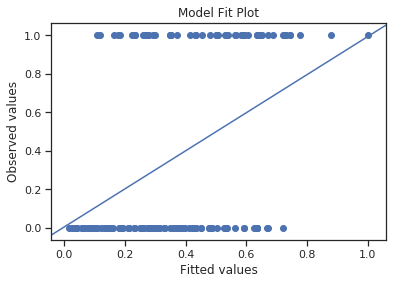

In [36]:
# Binomial model
data1['gamer'] = data1['nr_install_games'].apply(lambda x: 1 if x > 4 else 0)

mod = smf.glm(formula='gamer ~ C(gender) + C(position) + C(earning_year) + C(compensation_share_data) + C(value_pers_data) + C(privacy_feelings) + C(smartphone_kind) + C(age_group)', data=data1, family=sm.families.Binomial())
res = mod.fit()
display(res.summary())

nobs = res.nobs
y = res._endog[:]
yhat = res.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

3.8.3) CONCLUSION

Neither a NegativeBinomial nor a Binomial model (after thresholding the number of games install) find any significant effect.

# 3.9) Who are the best buyers (purchasing apps)?

3.9.1) PRELIMINARY DESCRIPTIVE PLOTS 

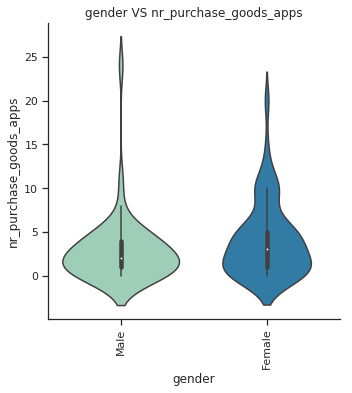

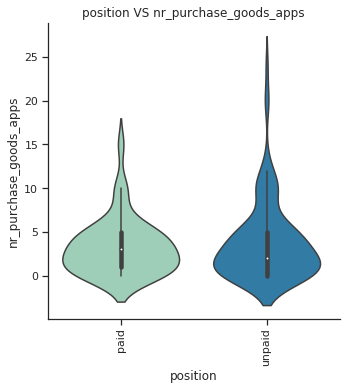

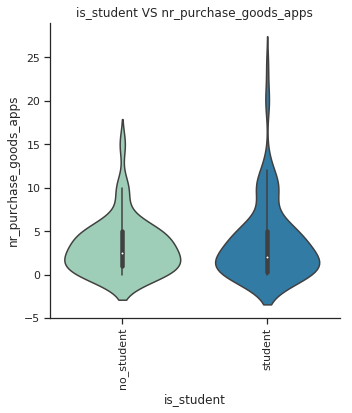

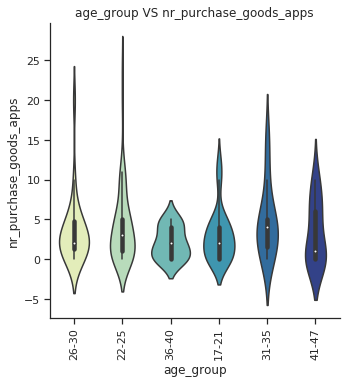

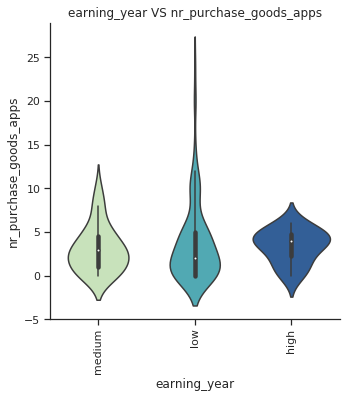

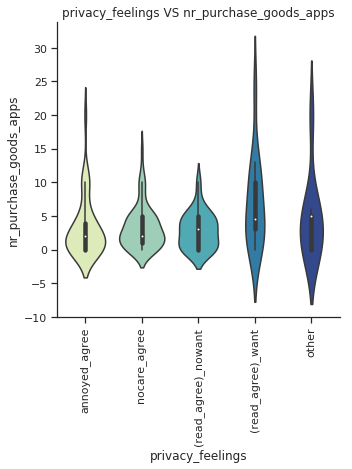

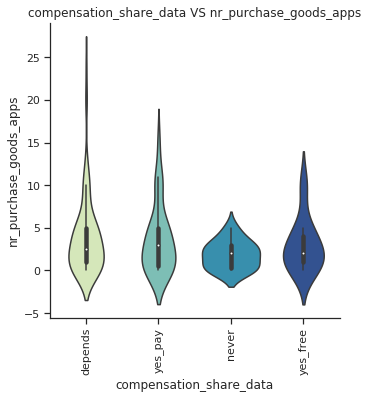

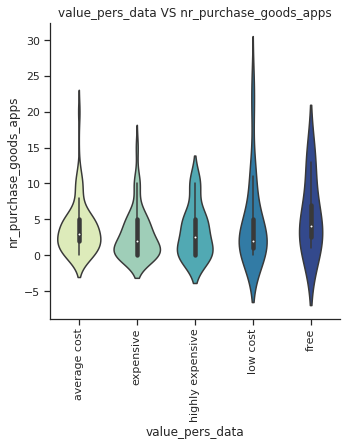

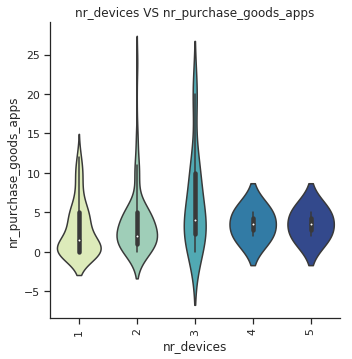

In [37]:
plot_violin(data1.drop(data1[data1['gender'] == 'non-binary'].index), 
            ['gender', 'position', 'is_student', 'age_group', 'earning_year', 
             'privacy_feelings', 'compensation_share_data', 'value_pers_data', 'nr_devices'],
            'nr_purchase_goods_apps','YlGnBu')

The following observations can be made from this preliminary analysis:

    - The majority of the distributions appear to be normal with some predictors having long-tail distributions either above the third quartile or below the first quartile;
    - The users who install more goods purchase apps  appear to be female;
    - Paid users seem to install more good purchase apps than unpaid (students and interns) userTs;
    - Older users (age_group 41-47) seem to install less purchase goods apps than the older (younger?) ones;
    - The users earning less seem to install less purchase goods apps  than users having medium and high earnings;
    - The users who agree to privacy policies when they want seem to install more purchase goods apps.
    - The users who want compensation for sharing data seen to instal more purchase goods apps.
    - The users who value their personal data as free seem to download more than other users;
    
Let's find a model to fit the data in order to check if the previous results are sttistical relevant.

3.9.2) MODEL

a) ASSUMPTIONS:

- see 3.1.2)

b) MODEL:

    - dependent variable Y = 'nr_purchase_goods_apps'
    
    - independent explanatory variables x1, x2, ..xn =  
    'gender', 'position', 'earning_year', 'where', 'age_group','privacy_feelings', 'compensation_share_data', 'value_pers_data', 'smartphone_kind', 'nr_devices' 

negative binomial
Optimization terminated successfully.
         Current function value: 2.297546
         Iterations: 56
         Function evaluations: 58
         Gradient evaluations: 58


<class 'statsmodels.iolib.summary.Summary'>
"""
                       NegativeBinomial Regression Results                        
==================================================================================
Dep. Variable:     nr_purchase_goods_apps   No. Observations:                  160
Model:                   NegativeBinomial   Df Residuals:                      136
Method:                               MLE   Df Model:                           23
Date:                    Sat, 27 Apr 2019   Pseudo R-squ.:                 0.04666
Time:                            20:09:22   Log-Likelihood:                -367.61
converged:                           True   LL-Null:                       -385.60
                                            LLR p-value:                   0.04144
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.9463      0.483      1.960      0.050   -6.02e-05       1.893
C(gender)[T.Male]                           -0.4073      0.192     -2.119      0.034      -0.784      -0.031
C(position)[T.unpaid]                        0.3061      0.300      1.021      0.307      -0.282       0.894
C(earning_year)[T.low]                      -0.4147      0.406     -1.022      0.307      -1.210       0.381
C(earning_year)[T.medium]                   -0.2708      0.403     -0.672      0.502      -1.061       0.520
C(compensation_share_data)[T.never]         -0.5014      0.340     -1.473      0.141      -1.169       0.166
C(compensation_share_data)[T.yes_free]      -0.5490      0.426     -1.288      0.198      -1.384       0.286
C(compensation_share_data)[T.yes_pay]        0.1011      0.228      0.443      0.657      -0.346       0.548
C(value_pers_data)[T.expensive]             -0.2890      0.226     -1.281      0.200      -0.731       0.153
C(value_pers_data)[T.free]                   0.3202      0.563      0.569      0.569      -0.783       1.423
C(value_pers_data)[T.highly expensive]      -0.1006      0.293     -0.343      0.732      -0.676       0.474
C(value_pers_data)[T.low cost]               0.3588      0.268      1.339      0.181      -0.166       0.884
C(privacy_feelings)[T.(read_agree)_want]     1.0014      0.363      2.758      0.006       0.290       1.713
C(privacy_feelings)[T.annoyed_agree]         0.0735      0.293      0.251      0.802      -0.501       0.648
C(privacy_feelings)[T.nocare_agree]          0.0891      0.267      0.334      0.738      -0.434       0.612
C(privacy_feelings)[T.other]                 0.5123      0.411      1.247      0.212      -0.293       1.317
C(smartphone_kind)[T.Android and iOS]       -0.2657      0.787     -0.337      0.736      -1.809       1.278
C(smartphone_kind)[T.iOS]                    0.3191      0.184      1.739      0.082      -0.041       0.679
C(smartphone_kind)[T.other]                 -0.2767      0.390     -0.710      0.478      -1.040       0.487
C(age_group)[T.22-25]                        0.3437      0.226      1.520      0.129      -0.099       0.787
C(age_group)[T.26-30]                        0.3739      0.297      1.259      0.208      -0.208       0.956
C(age_group)[T.31-35]                        0.8515      0.443      1.922      0.055      -0.017       1.720
C(age_group)[T.36-40]                       -0.2812      0.420     -0.669      0.504      -1.105       0.543
C(age_group)[T.41-47]                        0.3600      0.432      0.833      0.405      -0.487       1.207
alpha                                        0.6812      0.128      5.315      0.000       0.430       0.932
============================================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     nr_purchase_goods_apps   No. Observations:                  160
Model:                                GLM   Df Residuals:                      136
Model Family:            NegativeBinomial   Df Model:                           23
Link Function:                        log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -367.61
Date:                    Sat, 27 Apr 2019   Deviance:                       186.91
Time:                            20:09:22   Pearson chi2:                     131.
No. Iterations:                        12   Covariance Type:             nonrobust
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.9462      0.489      1.935      0.053      -0.012       1.905
C(gender)[T.Male]                           -0.4074      0.188     -2.165      0.030      -0.776      -0.039
C(position)[T.unpaid]                        0.3062      0.290      1.054      0.292      -0.263       0.876
C(earning_year)[T.low]                      -0.4148      0.394     -1.054      0.292      -1.186       0.357
C(earning_year)[T.medium]                   -0.2709      0.397     -0.683      0.495      -1.048       0.506
C(compensation_share_data)[T.never]         -0.5015      0.351     -1.430      0.153      -1.189       0.186
C(compensation_share_data)[T.yes_free]      -0.5491      0.422     -1.300      0.194      -1.377       0.279
C(compensation_share_data)[T.yes_pay]        0.1011      0.225      0.450      0.653      -0.340       0.542
C(value_pers_data)[T.expensive]             -0.2889      0.210     -1.373      0.170      -0.701       0.124
C(value_pers_data)[T.free]                   0.3206      0.556      0.577      0.564      -0.769       1.410
C(value_pers_data)[T.highly expensive]      -0.1005      0.299     -0.336      0.737      -0.687       0.486
C(value_pers_data)[T.low cost]               0.3589      0.257      1.398      0.162      -0.144       0.862
C(privacy_feelings)[T.(read_agree)_want]     1.0014      0.353      2.839      0.005       0.310       1.693
C(privacy_feelings)[T.annoyed_agree]         0.0736      0.291      0.253      0.800      -0.497       0.644
C(privacy_feelings)[T.nocare_agree]          0.0891      0.264      0.337      0.736      -0.429       0.607
C(privacy_feelings)[T.other]                 0.5123      0.423      1.212      0.225      -0.316       1.341
C(smartphone_kind)[T.Android and iOS]       -0.2655      0.779     -0.341      0.733      -1.793       1.262
C(smartphone_kind)[T.iOS]                    0.3191      0.181      1.758      0.079      -0.037       0.675
C(smartphone_kind)[T.other]                 -0.2767      0.383     -0.722      0.470      -1.028       0.474
C(age_group)[T.22-25]                        0.3437      0.222      1.549      0.121      -0.091       0.779
C(age_group)[T.26-30]                        0.3740      0.293      1.275      0.202      -0.201       0.949
C(age_group)[T.31-35]                        0.8515      0.427      1.996      0.046       0.015       1.688
C(age_group)[T.36-40]                       -0.2812      0.421     -0.668      0.504      -1.107       0.544
C(age_group)[T.41-47]                        0.3600      0.419      0.860      0.390      -0.461       1.181
============================================================================================================
"""

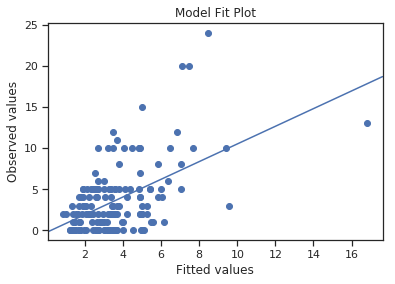

In [38]:
# Negative binomial
mod = negativeBinomial(formula='nr_purchase_goods_apps ~ C(gender) + C(position) + C(earning_year) + C(compensation_share_data) + C(value_pers_data) + C(privacy_feelings) + C(smartphone_kind) + C(age_group) ', data=data1[data1['gender'] != 'non-binary'])
res = mod.fit()
display(res.summary())

nobs = res.nobs
y = res._endog[:]
yhat = res.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

3.9.3) CONCLUSIONS

    The results does not seem to be statistically significant. 

# 3.10) Who are the best subscribers?

3.10.1) PRELIMINARY DESCRIPTIVE PLOTS

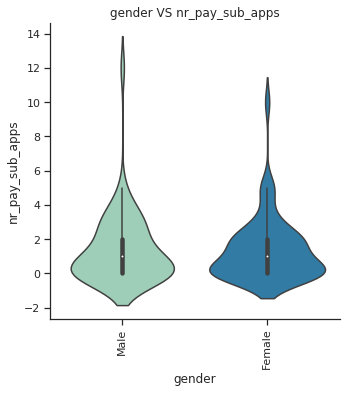

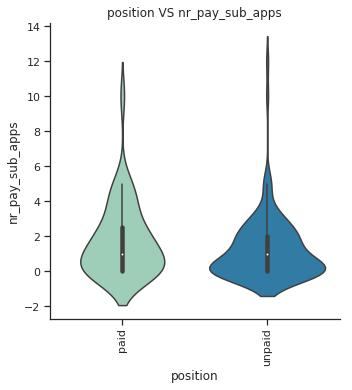

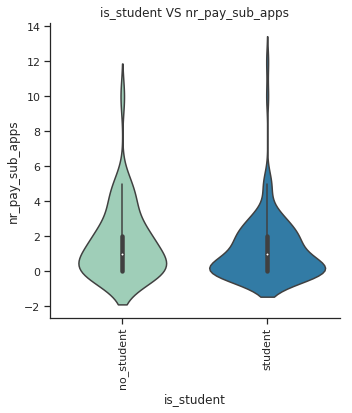

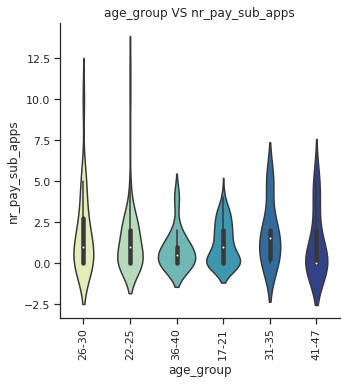

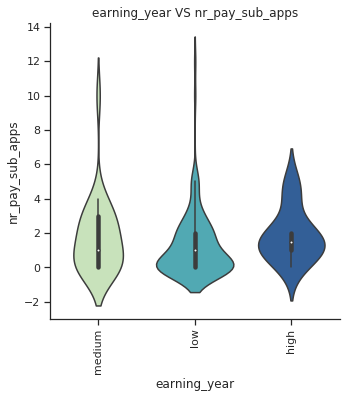

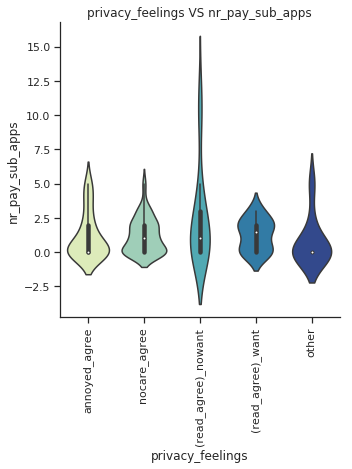

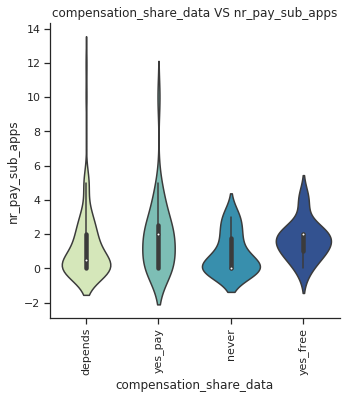

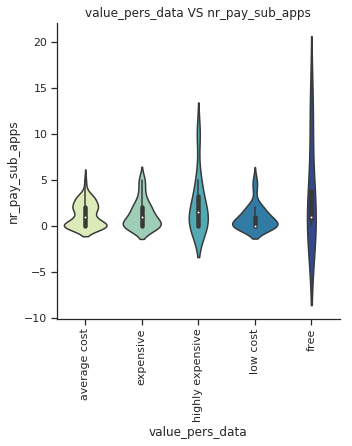

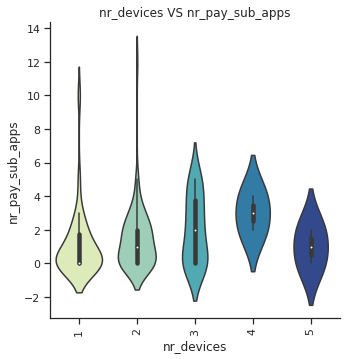

In [39]:
plot_violin(data1.drop(data1[data1['gender'] == 'non-binary'].index), 
            ['gender', 'position', 'is_student', 'age_group', 'earning_year', 
             'privacy_feelings', 'compensation_share_data', 'value_pers_data', 'nr_devices'],
            'nr_pay_sub_apps','YlGnBu')

The following observations can be made from this preliminary analysis:
    
    - The majority of the distributions appear to be normal with some predictors having long-tail distributions either above the third quartile or below the first quartile;
    - The users seem to install subscription apps indipendently by their gender;
    - Paid users seem to install slyghtly more subscription apps than unpaid (students and interns) users;
    - Older users (age_group 41-47) seem to install less subscription apps than the older ones;
    - The users earning less seem to install less subscription apps  than users having medium and high earnings;
    - The users who are annoyed by privacy policies but agree to them anyway seem to install less subscription apps.
    - The users who usually share data either for free or with compensation seem to install more subscription apps.
    - The users who value their personal data as 'low cost' seem to download less subscription apps than other users;
    
Let's find a model to fit the data in order to check if the previous results are statistical relevant.

3.10.2) MODEL

a) ASSUMPTIONS:

- see 3.1.2)

b) MODEL:

- dependent variable Y = 'nr_pay_sub_apps'
- independent explanatory variables x1, x2, ..xn =  
'gender', 'position', 'earning_year', 
'where', 'age_group','privacy_feelings',
'compensation_share_data', 'value_pers_data', 
'smartphone_kind', 'nr_devices'

negative binomial
Optimization terminated successfully.
         Current function value: 1.511615
         Iterations: 55
         Function evaluations: 56
         Gradient evaluations: 56


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:        nr_pay_sub_apps   No. Observations:                  160
Model:               NegativeBinomial   Df Residuals:                      136
Method:                           MLE   Df Model:                           23
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                 0.06626
Time:                        20:11:04   Log-Likelihood:                -241.86
converged:                       True   LL-Null:                       -259.02
                                        LLR p-value:                   0.06061
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.8524      0.562      1.516      0.129      -0.249       1.954
C(gender)[T.Male]                            0.1428      0.234      0.609      0.542      -0.317       0.602
C(position)[T.unpaid]                       -0.0976      0.336     -0.290      0.772      -0.757       0.562
C(earning_year)[T.low]                      -0.4789      0.444     -1.079      0.281      -1.349       0.391
C(earning_year)[T.medium]                   -0.1309      0.447     -0.293      0.770      -1.008       0.746
C(compensation_share_data)[T.never]         -0.7730      0.429     -1.800      0.072      -1.615       0.069
C(compensation_share_data)[T.yes_free]       0.4154      0.494      0.842      0.400      -0.552       1.383
C(compensation_share_data)[T.yes_pay]        0.2501      0.264      0.948      0.343      -0.267       0.767
C(value_pers_data)[T.expensive]              0.0130      0.257      0.051      0.960      -0.490       0.516
C(value_pers_data)[T.free]                   0.8448      0.575      1.469      0.142      -0.283       1.972
C(value_pers_data)[T.highly expensive]       0.6037      0.336      1.796      0.073      -0.055       1.263
C(value_pers_data)[T.low cost]              -0.4841      0.367     -1.317      0.188      -1.204       0.236
C(privacy_feelings)[T.(read_agree)_want]    -0.2998      0.439     -0.683      0.495      -1.161       0.561
C(privacy_feelings)[T.annoyed_agree]        -0.3742      0.333     -1.124      0.261      -1.027       0.278
C(privacy_feelings)[T.nocare_agree]         -0.4365      0.298     -1.464      0.143      -1.021       0.148
C(privacy_feelings)[T.other]                -1.1091      0.587     -1.890      0.059      -2.260       0.041
C(smartphone_kind)[T.Android and iOS]       -0.1518      0.905     -0.168      0.867      -1.926       1.622
C(smartphone_kind)[T.iOS]                    0.3157      0.223      1.416      0.157      -0.121       0.753
C(smartphone_kind)[T.other]                 -0.9816      0.586     -1.675      0.094      -2.130       0.167
C(age_group)[T.22-25]                       -0.0065      0.281     -0.023      0.982      -0.558       0.545
C(age_group)[T.26-30]                        0.1046      0.354      0.296      0.767      -0.589       0.798
C(age_group)[T.31-35]                        0.1433      0.523      0.274      0.784      -0.883       1.169
C(age_group)[T.36-40]                       -0.8751      0.544     -1.609      0.108      -1.941       0.191
C(age_group)[T.41-47]                        0.2082      0.532      0.391      0.696      -0.835       1.251
alpha                                        0.6222      0.193      3.225      0.001       0.244       1.000
============================================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        nr_pay_sub_apps   No. Observations:                  160
Model:                            GLM   Df Residuals:                      136
Model Family:        NegativeBinomial   Df Model:                           23
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -241.86
Date:                Sat, 27 Apr 2019   Deviance:                       169.35
Time:                        20:11:04   Pearson chi2:                     151.
No. Iterations:                    17   Covariance Type:             nonrobust
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.8525      0.566      1.507      0.132      -0.256       1.961
C(gender)[T.Male]                            0.1428      0.223      0.641      0.521      -0.294       0.579
C(position)[T.unpaid]                       -0.0976      0.329     -0.297      0.767      -0.742       0.547
C(earning_year)[T.low]                      -0.4790      0.445     -1.076      0.282      -1.352       0.394
C(earning_year)[T.medium]                   -0.1310      0.446     -0.294      0.769      -1.005       0.743
C(compensation_share_data)[T.never]         -0.7732      0.419     -1.847      0.065      -1.594       0.047
C(compensation_share_data)[T.yes_free]       0.4156      0.501      0.829      0.407      -0.567       1.398
C(compensation_share_data)[T.yes_pay]        0.2501      0.260      0.964      0.335      -0.259       0.759
C(value_pers_data)[T.expensive]              0.0130      0.251      0.052      0.959      -0.478       0.504
C(value_pers_data)[T.free]                   0.8447      0.586      1.441      0.150      -0.304       1.994
C(value_pers_data)[T.highly expensive]       0.6038      0.333      1.810      0.070      -0.050       1.257
C(value_pers_data)[T.low cost]              -0.4841      0.361     -1.340      0.180      -1.192       0.224
C(privacy_feelings)[T.(read_agree)_want]    -0.2998      0.417     -0.718      0.473      -1.118       0.518
C(privacy_feelings)[T.annoyed_agree]        -0.3742      0.323     -1.158      0.247      -1.008       0.259
C(privacy_feelings)[T.nocare_agree]         -0.4365      0.288     -1.515      0.130      -1.001       0.128
C(privacy_feelings)[T.other]                -1.1090      0.577     -1.924      0.054      -2.239       0.021
C(smartphone_kind)[T.Android and iOS]       -0.1514      0.905     -0.167      0.867      -1.925       1.622
C(smartphone_kind)[T.iOS]                    0.3158      0.220      1.436      0.151      -0.115       0.747
C(smartphone_kind)[T.other]                 -0.9811      0.582     -1.686      0.092      -2.122       0.160
C(age_group)[T.22-25]                       -0.0065      0.276     -0.024      0.981      -0.547       0.534
C(age_group)[T.26-30]                        0.1046      0.347      0.302      0.763      -0.575       0.784
C(age_group)[T.31-35]                        0.1430      0.505      0.283      0.777      -0.846       1.132
C(age_group)[T.36-40]                       -0.8749      0.534     -1.639      0.101      -1.921       0.171
C(age_group)[T.41-47]                        0.2080      0.510      0.408      0.684      -0.792       1.208
============================================================================================================
"""

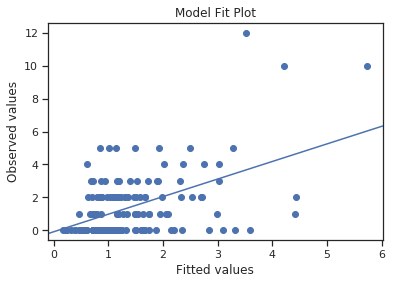

In [41]:
# Negative Binomial
mod = negativeBinomial(formula='nr_pay_sub_apps ~ C(gender) + C(position) + C(earning_year) + C(compensation_share_data) + C(value_pers_data) + C(privacy_feelings) + C(smartphone_kind) + C(age_group) ', data=data1[data1['gender'] != 'non-binary'])
res = mod.fit()
display(res.summary())

nobs = res.nobs
y = res._endog[:]
yhat = res.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

3.10.3) CONCLUSIONS

    The results does not seem to be statistically significant. 

# 3.11) Who is addicted to socials?

3.11.1) PRELIMINARY DESCRIPTIVE PLOTS

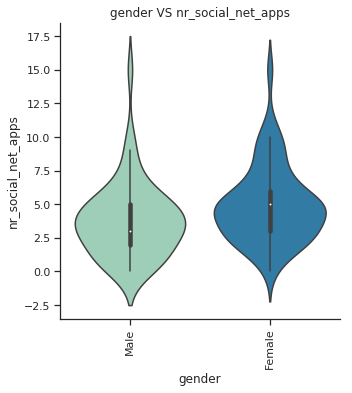

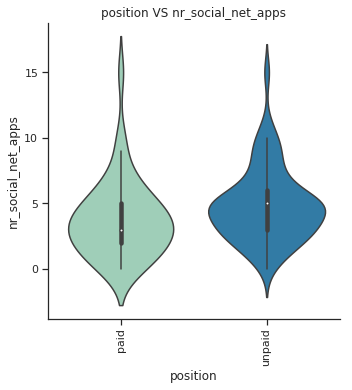

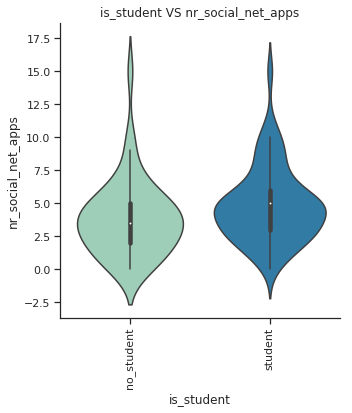

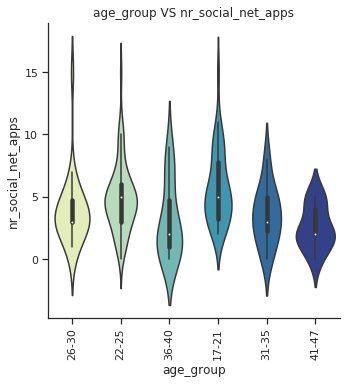

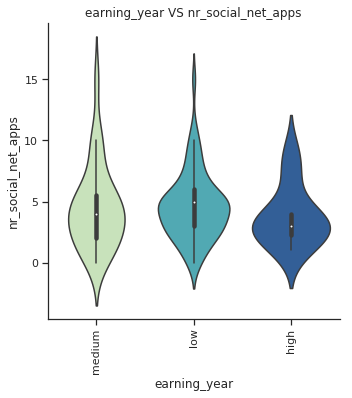

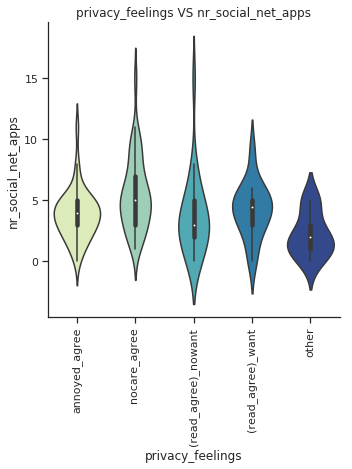

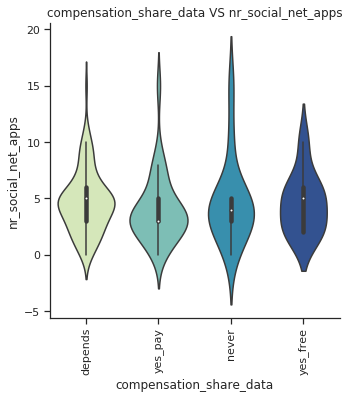

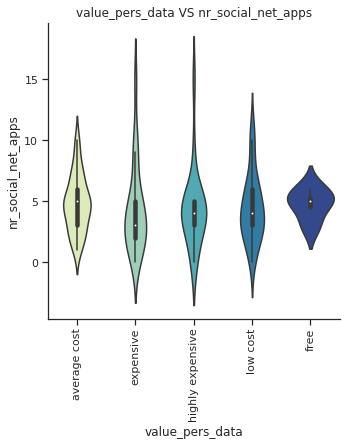

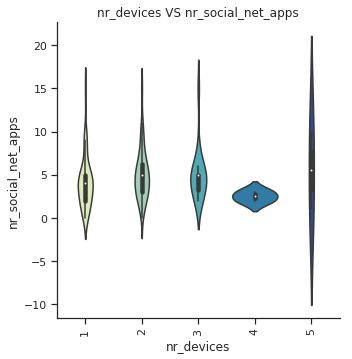

In [42]:
plot_violin(data1.drop(data1[data1['gender'] == 'non-binary'].index), 
            ['gender', 'position', 'is_student', 'age_group', 'earning_year', 
             'privacy_feelings', 'compensation_share_data', 'value_pers_data', 'nr_devices'],
            'nr_social_net_apps','YlGnBu')

The following observations can be made from this preliminary analysis:
    
    - The majority of the distributions appear to be normal with some predictors having long-tail distributions either above the third quartile or below the first quartile;
    - The female users seem to install more social network apps than Male users;
    - Unpaid users seem to install more social network apps than unpaid (students and interns) users;
    - The students seem to install more social network apps than no students;
    - The younger users (age_group 17-21 and 22-25) seem to install more social network apps than the older ones;
    - The users earning less seem to install more social network apps  than users having medium and high earnings;
    - The users to don't care about privacy policies on application but agree to them and the users that agree to these policies when they want seem to install more social network apps;
    
Let's find a model to fit the data in order to check if the previous results are statistical relevant.

3.11.2) MODEL

negative binomial
Optimization terminated successfully.
         Current function value: 2.222292
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:     nr_social_net_apps   No. Observations:                  160
Model:               NegativeBinomial   Df Residuals:                      136
Method:                           MLE   Df Model:                           23
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                 0.06375
Time:                        20:11:10   Log-Likelihood:                -355.57
converged:                       True   LL-Null:                       -379.78
                                        LLR p-value:                  0.001478
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    1.5518      0.277      5.599      0.000       1.009       2.095
C(gender)[T.Male]                           -0.1418      0.103     -1.375      0.169      -0.344       0.060
C(position)[T.unpaid]                        0.0778      0.158      0.492      0.623      -0.232       0.388
C(earning_year)[T.low]                      -0.1357      0.223     -0.609      0.543      -0.572       0.301
C(earning_year)[T.medium]                   -0.0371      0.224     -0.165      0.869      -0.476       0.402
C(compensation_share_data)[T.never]         -0.0617      0.172     -0.359      0.720      -0.398       0.275
C(compensation_share_data)[T.yes_free]       0.0956      0.230      0.415      0.678      -0.355       0.547
C(compensation_share_data)[T.yes_pay]       -0.0838      0.126     -0.668      0.504      -0.330       0.162
C(value_pers_data)[T.expensive]             -0.0017      0.111     -0.015      0.988      -0.219       0.215
C(value_pers_data)[T.free]                   0.0095      0.307      0.031      0.975      -0.591       0.610
C(value_pers_data)[T.highly expensive]       0.0384      0.162      0.237      0.813      -0.280       0.357
C(value_pers_data)[T.low cost]              -0.1660      0.144     -1.151      0.250      -0.449       0.117
C(privacy_feelings)[T.(read_agree)_want]     0.0997      0.203      0.490      0.624      -0.299       0.498
C(privacy_feelings)[T.annoyed_agree]         0.0554      0.162      0.342      0.733      -0.262       0.373
C(privacy_feelings)[T.nocare_agree]          0.2627      0.144      1.822      0.068      -0.020       0.545
C(privacy_feelings)[T.other]                -0.5257      0.281     -1.868      0.062      -1.077       0.026
C(smartphone_kind)[T.Android and iOS]       -0.0162      0.477     -0.034      0.973      -0.951       0.919
C(smartphone_kind)[T.iOS]                    0.1812      0.097      1.870      0.061      -0.009       0.371
C(smartphone_kind)[T.other]                  0.2293      0.197      1.163      0.245      -0.157       0.616
C(age_group)[T.22-25]                       -0.0628      0.112     -0.560      0.575      -0.283       0.157
C(age_group)[T.26-30]                       -0.3188      0.159     -2.001      0.045      -0.631      -0.006
C(age_group)[T.31-35]                       -0.3190      0.248     -1.287      0.198      -0.805       0.167
C(age_group)[T.36-40]                       -0.4893      0.238     -2.057      0.040      -0.956      -0.023
C(age_group)[T.41-47]                       -0.6525      0.263     -2.484      0.013      -1.167      -0.138
alpha                                        0.0656      0.031      2.118      0.034       0.005       0.126
============================================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     nr_social_net_apps   No. Observations:                  160
Model:                            GLM   Df Residuals:                      136
Model Family:        NegativeBinomial   Df Model:                           23
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -355.57
Date:                Sat, 27 Apr 2019   Deviance:                       166.71
Time:                        20:11:10   Pearson chi2:                     173.
No. Iterations:                     6   Covariance Type:             nonrobust
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    1.5518      0.275      5.652      0.000       1.014       2.090
C(gender)[T.Male]                           -0.1418      0.103     -1.382      0.167      -0.343       0.059
C(position)[T.unpaid]                        0.0778      0.159      0.490      0.624      -0.233       0.389
C(earning_year)[T.low]                      -0.1357      0.220     -0.615      0.538      -0.568       0.296
C(earning_year)[T.medium]                   -0.0370      0.224     -0.165      0.869      -0.475       0.401
C(compensation_share_data)[T.never]         -0.0617      0.173     -0.357      0.721      -0.401       0.277
C(compensation_share_data)[T.yes_free]       0.0956      0.230      0.416      0.678      -0.355       0.546
C(compensation_share_data)[T.yes_pay]       -0.0838      0.124     -0.675      0.500      -0.327       0.160
C(value_pers_data)[T.expensive]             -0.0017      0.111     -0.015      0.988      -0.219       0.216
C(value_pers_data)[T.free]                   0.0094      0.305      0.031      0.975      -0.588       0.607
C(value_pers_data)[T.highly expensive]       0.0385      0.163      0.236      0.813      -0.281       0.358
C(value_pers_data)[T.low cost]              -0.1660      0.144     -1.151      0.250      -0.449       0.117
C(privacy_feelings)[T.(read_agree)_want]     0.0997      0.203      0.491      0.624      -0.299       0.498
C(privacy_feelings)[T.annoyed_agree]         0.0553      0.162      0.341      0.733      -0.263       0.373
C(privacy_feelings)[T.nocare_agree]          0.2627      0.145      1.817      0.069      -0.021       0.546
C(privacy_feelings)[T.other]                -0.5257      0.282     -1.864      0.062      -1.079       0.027
C(smartphone_kind)[T.Android and iOS]       -0.0166      0.477     -0.035      0.972      -0.952       0.919
C(smartphone_kind)[T.iOS]                    0.1812      0.097      1.872      0.061      -0.009       0.371
C(smartphone_kind)[T.other]                  0.2293      0.199      1.155      0.248      -0.160       0.619
C(age_group)[T.22-25]                       -0.0628      0.112     -0.563      0.573      -0.282       0.156
C(age_group)[T.26-30]                       -0.3188      0.158     -2.011      0.044      -0.629      -0.008
C(age_group)[T.31-35]                       -0.3190      0.247     -1.291      0.197      -0.803       0.165
C(age_group)[T.36-40]                       -0.4894      0.236     -2.072      0.038      -0.952      -0.026
C(age_group)[T.41-47]                       -0.6525      0.263     -2.484      0.013      -1.167      -0.138
============================================================================================================
"""

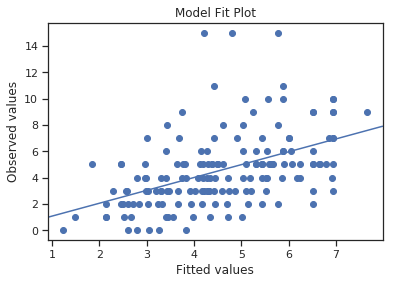

In [43]:
# Negative Binomial
mod = negativeBinomial(formula='nr_social_net_apps ~ C(gender) + C(position) + C(earning_year) + C(compensation_share_data) + C(value_pers_data) + C(privacy_feelings) + C(smartphone_kind) + C(age_group) ', data=data1[data1['gender'] != 'non-binary'])
res = mod.fit()
display(res.summary())

nobs = res.nobs
y = res._endog[:]
yhat = res.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

c) PARTIAL RESIDUAL PLOT

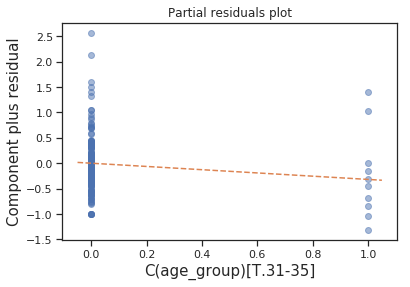

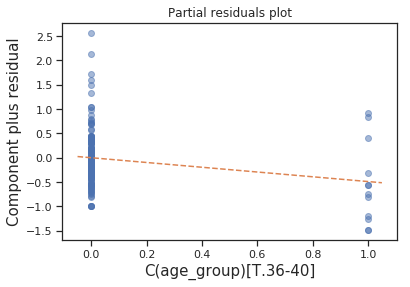

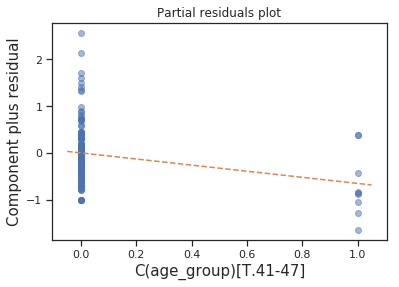

In [44]:
plot_partial_residual(res, col='C(age_group)[T.31-35]')
plot_partial_residual(res, col='C(age_group)[T.36-40]')
plot_partial_residual(res, col='C(age_group)[T.41-47]')

3.11.3) CONCLUSIONS

From the table and plots above, it can be noticed that the predictor variables C(age_group)[T.31-35], C(age_group)[T.36-40], C(age_group)[T.41-47]  are statistical significant as their p-values are less than 0.05. In particular the age_groups 31-35, 36-40, 41-47 seem to download less social network application than the younger users (respectively 53%, 68% and 73% less applications than younger users).

# 3.12) Who are people who are ready to give data for free?

In [45]:
data1['data_free'] = data1['compensation_share_data'].apply(lambda x: 1 if x == 'yes_free' else 0)
display(data1['data_free'].value_counts())
display(data1['compensation_share_data'].value_counts())

0    152
1      9
Name: data_free, dtype: int64

depends     107
yes_pay      31
never        14
yes_free      9
Name: compensation_share_data, dtype: int64

a) ASSUMPTIONS:

-  see point 3.1.2 a)

b) MODEL:

- dependent variable Y = 'data_free'
- independent explanatory variables x1, x2, ..xn = 'position', 'gender', 'industry', 'earning_year', 'age_group', 'where'

In [46]:
data1.columns

Index(['index', 'gender', 'position', 'industry', 'earning_year',
       'privacy_feelings', 'compensation_share_data', 'value_pers_data',
       'smartphone_kind', 'nr_devices', 'tot_install_apps', 'nr_install_games',
       'nr_purchase_goods_apps', 'nr_pay_sub_apps', 'nr_banks_apps',
       'nr_social_net_apps', 'nr_installed_payment_systems', 'where',
       'is_student', 'age_group', 'tot_install_apps_bucket',
       'nr_install_games_bucket', 'nr_purchase_goods_apps_bucket',
       'nr_pay_sub_apps_bucket', 'nr_banks_apps_bucket',
       'nr_social_net_apps_bucket', 'nr_installed_payment_systems_bucket',
       'gamer', 'data_free'],
      dtype='object')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              data_free   No. Observations:                  161
Model:                            GLM   Df Residuals:                      139
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.964
Date:                Sat, 27 Apr 2019   Deviance:                       47.929
Time:                        20:11:35   Pearson chi2:                     86.9
No. Iterations:                    23   Covariance Type:             nonrobust
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -1.0449      2.524     -0.414      0.679      -5.993       3.903
C(gender)[T.Male]                        1.8256      1.170      1.561      0.119      -0.467       4.118
C(gender)[T.non-binary]                -20.0928   1.31e+05     -0.000      1.000   -2.57e+05    2.57e+05
C(position)[T.unpaid]                   -0.2735      1.454     -0.188      0.851      -3.123       2.576
C(industry)[T.Education]                 0.6839      1.580      0.433      0.665      -2.413       3.780
C(industry)[T.Finance]                   0.1152      1.649      0.070      0.944      -3.116       3.346
C(industry)[T.Government]              -21.3845   4.61e+04     -0.000      1.000   -9.03e+04    9.03e+04
C(industry)[T.Healthcare]              -19.5111   2.79e+04     -0.001      0.999   -5.47e+04    5.47e+04
C(industry)[T.Non-profit]              -20.4234   4.41e+04     -0.000      1.000   -8.64e+04    8.64e+04
C(industry)[T.Professional Services]     3.1168      1.732      1.799      0.072      -0.279       6.512
C(industry)[T.Technology]                0.7718      1.517      0.509      0.611      -2.201       3.745
C(industry)[T.Transport]               -20.8828   7.48e+04     -0.000      1.000   -1.47e+05    1.47e+05
C(earning_year)[T.low]                  -3.8388      1.713     -2.242      0.025      -7.195      -0.482
C(earning_year)[T.medium]               -5.2564      2.416     -2.176      0.030      -9.992      -0.521
C(age_group)[T.22-25]                    1.2217      1.331      0.918      0.359      -1.387       3.831
C(age_group)[T.26-30]                   -2.0131      2.296     -0.877      0.380      -6.512       2.486
C(age_group)[T.31-35]                    0.5599      2.043      0.274      0.784      -3.445       4.565
C(age_group)[T.36-40]                  -25.6572   2.52e+04     -0.001      0.999   -4.94e+04    4.93e+04
C(age_group)[T.41-47]                  -21.1777    3.6e+04     -0.001      1.000   -7.06e+04    7.06e+04
C(where)[T.OTHER]                        2.7832      1.952      1.426      0.154      -1.042       6.608
C(where)[T.UK]                          -0.2660      1.040     -0.256      0.798      -2.304       1.772
C(where)[T.USA]                         -0.6328      1.136     -0.557      0.577      -2.859       1.593
========================================================================================================
"""

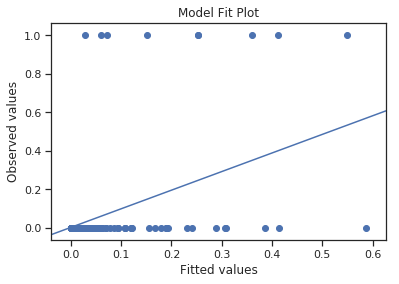

In [47]:
formula='data_free ~ C(gender) + C(position) + C(industry) + C(earning_year) + C(age_group) + C(where)'
mod = smf.glm(formula=formula, data=data1, family=sm.families.Binomial())

res = mod.fit()

display(res.summary())


nobs = res.nobs
y = res._endog[:]
yhat = mod.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

3.12.3) CONCLUSIONS

  Statsmodels dedicated Binomial solver (not shown) does not converge. GLM binomial model converges but produces non-sensical p-values. The issue is that the number of samples of people that would are ready to share personal information for free is below the minimum (9) required for a logistical regression.

# 3.13) Who are people who are williing to be paid to share data?

In [49]:
data1['data_no_free'] = data1['compensation_share_data'].apply(lambda x: 1 if x == 'yes_pay' else 0)
display(data1['data_no_free'].value_counts())

0    130
1     31
Name: data_no_free, dtype: int64

3.13.1) MODEL

a) ASSUMPTIONS:

-  see point 3.1.2 a)

b) MODEL:

- dependent variable Y = 'data_no_free'
- independent explanatory variables x1, x2, ..xn = 'position', 'gender', 'industry', 'earning_year', 'age_group', 'where'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           data_no_free   No. Observations:                  161
Model:                            GLM   Df Residuals:                      139
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -66.421
Date:                Sat, 27 Apr 2019   Deviance:                       132.84
Time:                        20:12:02   Pearson chi2:                     155.
No. Iterations:                    20   Covariance Type:             nonrobust
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -4.3299      1.804     -2.400      0.016      -7.866      -0.794
C(gender)[T.Male]                        0.2934      0.507      0.579      0.563      -0.700       1.287
C(gender)[T.non-binary]                -19.1792   2.92e+04     -0.001      0.999   -5.73e+04    5.73e+04
C(position)[T.unpaid]                   -1.8823      0.728     -2.585      0.010      -3.309      -0.455
C(industry)[T.Education]                 0.7505      0.733      1.024      0.306      -0.687       2.188
C(industry)[T.Finance]                   0.0635      1.272      0.050      0.960      -2.429       2.556
C(industry)[T.Government]                0.5625      1.434      0.392      0.695      -2.247       3.372
C(industry)[T.Healthcare]                0.3792      0.951      0.399      0.690      -1.484       2.242
C(industry)[T.Non-profit]                1.5457      1.128      1.371      0.170      -0.664       3.756
C(industry)[T.Professional Services]    -0.4915      1.015     -0.484      0.628      -2.481       1.498
C(industry)[T.Technology]                0.9341      0.790      1.183      0.237      -0.614       2.482
C(industry)[T.Transport]               -21.8522   1.61e+04     -0.001      0.999   -3.15e+04    3.15e+04
C(earning_year)[T.low]                   3.0748      1.418      2.168      0.030       0.295       5.854
C(earning_year)[T.medium]                1.6060      1.321      1.215      0.224      -0.984       4.196
C(age_group)[T.22-25]                    0.6709      0.657      1.021      0.307      -0.617       1.959
C(age_group)[T.26-30]                    0.3516      0.879      0.400      0.689      -1.371       2.074
C(age_group)[T.31-35]                    0.3874      1.105      0.351      0.726      -1.779       2.554
C(age_group)[T.36-40]                    1.9137      1.044      1.833      0.067      -0.133       3.960
C(age_group)[T.41-47]                   -0.3748      1.291     -0.290      0.772      -2.905       2.155
C(where)[T.OTHER]                       -0.2590      1.272     -0.204      0.839      -2.752       2.234
C(where)[T.UK]                           0.2927      0.617      0.474      0.635      -0.917       1.503
C(where)[T.USA]                          0.8101      0.614      1.318      0.187      -0.394       2.014
========================================================================================================
"""

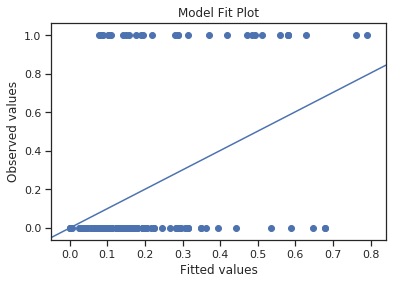

In [50]:
# Binomial
formula='data_no_free ~ C(gender) + C(position) + C(industry) + C(earning_year) + C(age_group) + C(where)'
mod = smf.glm(formula=formula, data=data1, family=sm.families.Binomial())

res = mod.fit()

display(res.summary())


nobs = res.nobs
y = res._endog[:]
yhat = mod.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

c) PARTIAL RESIDUAL PLOTS

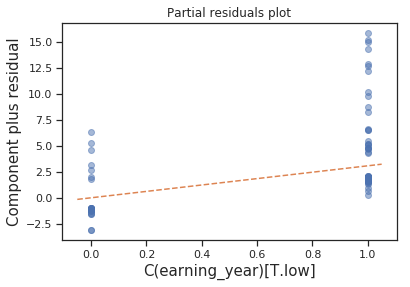

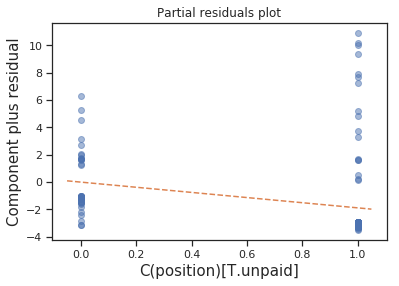

In [51]:
plot_partial_residual(res, col='C(earning_year)[T.low]')
plot_partial_residual(res, col='C(position)[T.unpaid]')

3.13.2) CONCLUSIONS

From the table and plots above, it can be noticed that the predictor variables C(earning_year)[T.low] and C(position)[T.unpaid] are statistical significant as their p-values are less than 0.05. 
The users earning a low amount of money are more willing to be paid to share data.
The unpaid users are less willing to be paid to share data.

# 3.14) Who are people who don't want to share data at all?

3.14.1) MODEL

In [52]:
data1['no_sharing'] = data1['compensation_share_data'].apply(lambda x: 1 if x == 'never' else 0)
display(data1['no_sharing'].value_counts())
display(data1['compensation_share_data'].value_counts())

0    147
1     14
Name: no_sharing, dtype: int64

depends     107
yes_pay      31
never        14
yes_free      9
Name: compensation_share_data, dtype: int64

a) ASSUMPTIONS:

-  see point 3.1.2 a)

b) MODEL:

- dependent variable Y = 'no_sharing'
- independent explanatory variables x1, x2, ..xn = 'position', 'gender', 'industry', 'earning_year', 'age_group', 'where'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             no_sharing   No. Observations:                  161
Model:                            GLM   Df Residuals:                      139
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38.172
Date:                Sat, 27 Apr 2019   Deviance:                       76.343
Time:                        20:14:04   Pearson chi2:                     121.
No. Iterations:                    22   Covariance Type:             nonrobust
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -2.3268      2.181     -1.067      0.286      -6.602       1.949
C(gender)[T.Male]                        0.6219      0.699      0.889      0.374      -0.749       1.993
C(gender)[T.non-binary]                -21.3911   7.95e+04     -0.000      1.000   -1.56e+05    1.56e+05
C(position)[T.unpaid]                    2.6354      1.471      1.792      0.073      -0.247       5.518
C(industry)[T.Education]                -0.9690      0.925     -1.048      0.295      -2.781       0.843
C(industry)[T.Finance]                  -1.1265      1.270     -0.887      0.375      -3.615       1.362
C(industry)[T.Government]                0.0914      1.398      0.065      0.948      -2.648       2.830
C(industry)[T.Healthcare]                0.2709      1.070      0.253      0.800      -1.826       2.368
C(industry)[T.Non-profit]                0.4709      1.505      0.313      0.754      -2.479       3.421
C(industry)[T.Professional Services]   -20.8127   1.85e+04     -0.001      0.999   -3.62e+04    3.62e+04
C(industry)[T.Technology]               -1.4486      1.046     -1.385      0.166      -3.498       0.601
C(industry)[T.Transport]               -23.5221   4.57e+04     -0.001      1.000   -8.96e+04    8.95e+04
C(earning_year)[T.low]                  -1.5146      1.478     -1.025      0.305      -4.411       1.381
C(earning_year)[T.medium]               -0.0621      1.542     -0.040      0.968      -3.084       2.960
C(age_group)[T.22-25]                   -0.4104      0.800     -0.513      0.608      -1.979       1.158
C(age_group)[T.26-30]                    0.5016      1.044      0.481      0.631      -1.544       2.547
C(age_group)[T.31-35]                  -20.0116   2.12e+04     -0.001      0.999   -4.15e+04    4.15e+04
C(age_group)[T.36-40]                    0.5571      1.514      0.368      0.713      -2.409       3.524
C(age_group)[T.41-47]                  -21.5826   2.45e+04     -0.001      0.999    -4.8e+04     4.8e+04
C(where)[T.OTHER]                        1.1429      1.147      0.996      0.319      -1.106       3.391
C(where)[T.UK]                          -0.5629      0.784     -0.718      0.472      -2.099       0.973
C(where)[T.USA]                         -1.5359      1.053     -1.459      0.145      -3.599       0.527
========================================================================================================
"""

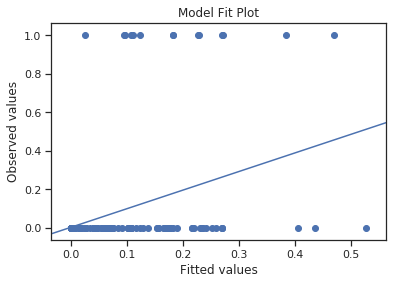

In [53]:
formula='no_sharing ~ C(gender) + C(position) + C(industry) + C(earning_year) + C(age_group) + C(where)'
mod = smf.glm(formula=formula, data=data1, family=sm.families.Binomial())

res = mod.fit()

display(res.summary())


nobs = res.nobs
y = res._endog[:]
yhat = mod.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

3.14.2) CONCLUSIONS
  
statsmodels dedicated Binomial solver (not shown) does not converge. GLM binomial model converges but produces non-sensical p-values. The issue is that the number of samples of people that would never share personal information is below the minimum (13) required for a logistical regression.